# New Code

In [4]:
import os
import pickle
import numpy as np
import uproot
import awkward as ak
from sklearn.preprocessing import RobustScaler

file = uproot.open('/storage/mxg1065/datafiles/xAODAnalysis_1000events.outputs.root')
print(file.keys())
tree = file['analysis;1']
branches = tree.arrays()
print(tree.keys()) # Variables per event

# Extract arrays - properly handle awkward arrays
cell_snr = ak.to_numpy(branches['cell_SNR'])
cell_eta = ak.to_numpy(branches['cell_eta'])
cell_phi = ak.to_numpy(branches['cell_phi'])
cell_noise = ak.to_numpy(branches['cell_noiseSigma'])
cell_to_cluster_index = ak.to_numpy(branches['cell_cluster_index'])
cell_e = ak.to_numpy(branches['cell_e'])

num_of_events = len(cell_snr)
num_of_cells = len(cell_snr[0])

# Identify broken cells (those with zero noise)
broken_cells_per_event = [np.squeeze(np.argwhere(cell_noise[i] == 0)) for i in range(num_of_events)]

# --- Build raw data dictionary ---
data = {}
valid_cell_indices = {}  # Store original cell indices per event

for i in range(num_of_events):
    valid_mask = cell_noise[i] != 0
    valid_cell_indices[f"indices_{i}"] = np.where(valid_mask)[0]
    
    features_raw = np.concatenate([
        np.expand_dims(cell_snr[i][valid_mask], axis=1),
        np.expand_dims(cell_eta[i][valid_mask], axis=1),   # raw η
        np.expand_dims(cell_phi[i][valid_mask], axis=1)    # raw φ
    ], axis=1)
    
    data[f"data_{i}"] = features_raw

# --- Build combined features for scaled_data ---
combined_data = []
for i in range(num_of_events):
    valid_mask = cell_noise[i] != 0
    features_scaled = np.concatenate([
        np.expand_dims(cell_snr[i][valid_mask], axis=1),   # will scale SNR later
        np.expand_dims(cell_eta[i][valid_mask], axis=1),   # raw η
        np.expand_dims(cell_phi[i][valid_mask], axis=1)    # raw φ
    ], axis=1)
    combined_data.append(features_scaled)

combined_data = np.vstack(combined_data)

# Scale only the first column (SNR) using RobustScaler
scaler = RobustScaler()
combined_data[:, 0] = scaler.fit_transform(combined_data[:, [0]]).ravel()

# --- Split back into event-wise "scaled_data" ---
scaled_data = {}
start_idx = 0
for i in range(num_of_events):
    n_cells = data[f"data_{i}"].shape[0]
    scaled_data[f"data_{i}"] = combined_data[start_idx:start_idx+n_cells]
    start_idx += n_cells

print(f"Scaled Data Shape for First Event: {scaled_data['data_0'].shape}")
print(f"Unscaled Data Shape for First Event: {data['data_0'].shape}\n")

# ============================================================================
# 1) LIST OF PAIRS WITH CELL ORDERING (Connectivity of the calorimeter)
# ============================================================================

# Use neighbor info from the first event - handle as awkward array
neighbor_awkward = branches['neighbor'][0]  # Keep as awkward array for now
neighbor_list = neighbor_awkward.tolist()   # Convert to Python list of lists

# Identify broken cells in the first event
broken_cells = broken_cells_per_event[0]

# Get valid cell indices for event 0
valid_cell_indices_event0 = valid_cell_indices["indices_0"]

# Create mapping from original index to contiguous index
index_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(valid_cell_indices_event0)}

# Create connectivity list ordered by cell index
connectivity_list = []

# For each cell in order (0, 1, 2, ...)
for orig_i in range(len(neighbor_list)):
    # Skip broken cells
    if orig_i in broken_cells:
        continue
        
    # Check if current cell is in valid indices
    if orig_i not in index_mapping:
        continue
        
    corrected_i = index_mapping[orig_i]
    cell_connections = []
    
    for orig_j in neighbor_list[orig_i]:
        orig_j = int(orig_j)
        
        # Skip broken or invalid neighbors
        if orig_j in broken_cells or orig_j not in index_mapping:
            continue
            
        # Map neighbor to corrected position
        corrected_j = index_mapping[orig_j]
        cell_connections.append(corrected_j)
    
    # Sort connections for consistency and add to main list
    connectivity_list.append((corrected_i, sorted(cell_connections)))

# Sort by cell index to ensure proper ordering
connectivity_list.sort(key=lambda x: x[0])

# Also create the flattened neighbor pairs array (for compatibility)
corrected_neighbor_pairs = []
for orig_i in range(len(neighbor_list)):
    if orig_i in broken_cells or orig_i not in index_mapping:
        continue
        
    for orig_j in neighbor_list[orig_i]:
        orig_j = int(orig_j)
        if orig_j in broken_cells or orig_j not in index_mapping:
            continue
            
        corrected_i = index_mapping[orig_i]
        corrected_j = index_mapping[orig_j]
        corrected_neighbor_pairs.append((corrected_i, corrected_j))

# Remove permutation variants for the pairs
def canonical_form(t):
    return tuple(sorted(t))

def remove_permutation_variants(tuple_list):
    unique_tuples = set(canonical_form(t) for t in tuple_list)
    return [tuple(sorted(t)) for t in unique_tuples]

unique_neighbor_pairs = remove_permutation_variants(corrected_neighbor_pairs)
neighbor_pairs_array = np.array(unique_neighbor_pairs, dtype=np.int32)

# ============================================================================
# 2) LIST OF EVENTS WITH ALL FEATURES (Ordered as event 0, event 1, etc.)
# ============================================================================

# Get the list of branch names once
branch_names = list(tree.keys())

# Store all event data in ordered list
events_data = []

for event_idx in range(num_of_events):
    event_dict = {}
    
    # Store all available branches for this event
    for branch_name in branch_names:
        try:
            # Convert each branch to numpy array, handling jagged arrays properly
            branch_data = branches[branch_name][event_idx]
            if hasattr(branch_data, 'tolist'):
                # For jagged arrays, convert to list first then to numpy array if needed
                event_dict[branch_name] = branch_data
            else:
                event_dict[branch_name] = np.array(branch_data)
        except Exception as e:
            print(f"Warning: Could not process {branch_name} for event {event_idx}: {e}")
            event_dict[branch_name] = None
    
    # Also store the valid cell indices for this event
    event_dict['valid_cell_indices'] = valid_cell_indices[f"indices_{event_idx}"]
    
    # Store broken cells info
    event_dict['broken_cells'] = broken_cells_per_event[event_idx]
    
    events_data.append(event_dict)

# ============================================================================
# 3) TRUE LABELS OF PAIRS (Ordered same as neighbor_pairs_array)
# ============================================================================

# Initialize array for labels - use neighbor_pairs_array.shape[0] for proper size
labels_for_neighbor_pairs = np.zeros((num_of_events, neighbor_pairs_array.shape[0]), dtype=int)

# Extracting cells using the corrected indices array
cell_0 = cell_to_cluster_index[:, neighbor_pairs_array[:, 0]]
cell_1 = cell_to_cluster_index[:, neighbor_pairs_array[:, 1]]

# Computing labels
same_cluster = cell_0 == cell_1 
both_nonzero = (cell_0 != 0) & (cell_1 != 0)

labels_for_neighbor_pairs[same_cluster & (cell_0 == 0)] = 0  # Lone-Lone
labels_for_neighbor_pairs[same_cluster & (cell_0 != 0)] = 1  # True-True
labels_for_neighbor_pairs[~same_cluster & both_nonzero] = 4  # Cluster-Cluster
labels_for_neighbor_pairs[~same_cluster & (cell_0 == 0) & (cell_1 != 0)] = 3  # Lone-Cluster
labels_for_neighbor_pairs[~same_cluster & (cell_0 != 0) & (cell_1 == 0)] = 2  # Cluster-Lone

# ============================================================================
# 4) LIST OF CELLS AND THEIR ORDER
# ============================================================================

# For event 0 (reference geometry)
cells_list = []
for new_idx, orig_idx in enumerate(valid_cell_indices_event0):
    cell_info = {
        'original_index': orig_idx,
        'contiguous_index': new_idx,
        'eta': cell_eta[0][orig_idx],
        'phi': cell_phi[0][orig_idx],
        'snr': cell_snr[0][orig_idx],
        'energy': cell_e[0][orig_idx],
        'cluster_index': cell_to_cluster_index[0][orig_idx]
    }
    cells_list.append(cell_info)

# Sort by contiguous index to ensure proper ordering
cells_list.sort(key=lambda x: x['contiguous_index'])

# ============================================================================
# VERIFICATION AND SAVING
# ============================================================================

print("=" * 60)
print("DATA STRUCTURES CREATED:")
print("=" * 60)
print(f"1) Connectivity list: {len(connectivity_list)} cells with connections")
print(f"   Example: Cell {connectivity_list[0][0]} connects to {len(connectivity_list[0][1])} neighbors")
print(f"2) Events data: {len(events_data)} events with all features")
print(f"   Event 0 keys: {list(events_data[0].keys())}")
print(f"3) Labels shape: {labels_for_neighbor_pairs.shape}")
print(f"   Label distribution in first event: {np.unique(labels_for_neighbor_pairs[0], return_counts=True)}")
print(f"4) Cells list: {len(cells_list)} cells with complete information")
print(f"   First cell: original_idx={cells_list[0]['original_index']}, contiguous_idx={cells_list[0]['contiguous_index']}")

# Verify ordering
print("\n" + "=" * 60)
print("ORDERING VERIFICATION:")
print("=" * 60)
print(f"Connectivity list first 5 cells: {[x[0] for x in connectivity_list[:5]]}")
print(f"Cells list first 5 contiguous indices: {[x['contiguous_index'] for x in cells_list[:5]]}")
print(f"Neighbor pairs max index: {neighbor_pairs_array.max()}")
print(f"Cells list max index: {max(cell['contiguous_index'] for cell in cells_list)}")

# Save all data structures
load_path = "/storage/mxg1065/datafiles"

def save_pkl(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

# Save the four main data structures
save_pkl(connectivity_list, os.path.join(load_path, "connectivity_list_ordered.pkl"))
save_pkl(events_data, os.path.join(load_path, "events_data_complete.pkl"))
save_pkl(labels_for_neighbor_pairs, os.path.join(load_path, "labels_ordered.pkl"))
save_pkl(cells_list, os.path.join(load_path, "cells_list_ordered.pkl"))

# Also save the scaled data and neighbor pairs for compatibility
save_pkl(scaled_data, os.path.join(load_path, "scaled_data_1000events.pkl"))
save_pkl(neighbor_pairs_array, os.path.join(load_path, "neighbor_pairs_list.pkl"))

print("\n" + "=" * 60)
print("DATA SAVED SUCCESSFULLY!")
print("=" * 60)
print("Files created:")
print("1. connectivity_list_ordered.pkl - Cell connections ordered by cell index")
print("2. events_data_complete.pkl - All events with complete feature set")
print("3. labels_ordered.pkl - True labels matching neighbor pairs order")  
print("4. cells_list_ordered.pkl - All cells with metadata, ordered by index")
print("5. scaled_data_1000events.pkl - Scaled features (compatibility)")
print("6. neighbor_pairs_list.pkl - Neighbor pairs array (compatibility)")

['analysis;1']
['RunNumber', 'EventNumber', 'cell_eta', 'cell_phi', 'cell_x', 'cell_y', 'cell_z', 'cell_subCalo', 'cell_sampling', 'cell_size', 'cell_hashID', 'neighbor', 'seedCell_id', 'cell_e', 'cell_noiseSigma', 'cell_SNR', 'cell_time', 'cell_weight', 'cell_truth', 'cell_truth_indices', 'cell_shared_indices', 'cell_cluster_index', 'cluster_to_cell_indices', 'cluster_to_cell_weights', 'cell_to_cluster_e', 'cell_to_cluster_eta', 'cell_to_cluster_phi', 'cluster_eta', 'cluster_phi', 'cluster_e', 'cellsNo_cluster', 'clustersNo_event', 'jetEnergyWtdTimeAve', 'jetEta', 'jetPhi', 'jetE', 'jetPt', 'jetNumberPerEvent', 'cellIndices_per_jet']
Scaled Data Shape for First Event: (187650, 3)
Unscaled Data Shape for First Event: (187650, 3)

DATA STRUCTURES CREATED:
1) Connectivity list: 187650 cells with connections
   Example: Cell 0 connects to 12 neighbors
2) Events data: 1000 events with all features
   Event 0 keys: ['RunNumber', 'EventNumber', 'cell_eta', 'cell_phi', 'cell_x', 'cell_y', 'ce

# Old Code

In [1]:
import os
import pickle
import uproot
import shutil
import numpy as np
import awkward as ak
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
from collections import defaultdict





# Standard Library
import argparse
import lzma
import os
import pickle
import re
import signal
import time
import traceback
from copy import deepcopy
from typing import Any, Dict, List, Optional, Tuple

# Third-Party Libraries
import numpy as np
import torch
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, IterableDataset

# PyTorch Geometric
from torch_geometric.nn import GCNConv
from torch.nn import BatchNorm1d


# Set multiprocessing start method early
mp.set_start_method('spawn', force=True)

# Set global torch settings for better performance
torch.backends.cudnn.benchmark = True # Limits determinism
torch.set_num_threads(2)  # Limit CPU threads per process

In [2]:
file = uproot.open('/storage/mxg1065/datafiles/xAODAnalysis_1000events.outputs.root')
print(file.keys())
tree = file['analysis;1']
branches = tree.arrays()
print(tree.keys()) # Variables per event

['analysis;1']
['RunNumber', 'EventNumber', 'cell_eta', 'cell_phi', 'cell_x', 'cell_y', 'cell_z', 'cell_subCalo', 'cell_sampling', 'cell_size', 'cell_hashID', 'neighbor', 'seedCell_id', 'cell_e', 'cell_noiseSigma', 'cell_SNR', 'cell_time', 'cell_weight', 'cell_truth', 'cell_truth_indices', 'cell_shared_indices', 'cell_cluster_index', 'cluster_to_cell_indices', 'cluster_to_cell_weights', 'cell_to_cluster_e', 'cell_to_cluster_eta', 'cell_to_cluster_phi', 'cluster_eta', 'cluster_phi', 'cluster_e', 'cellsNo_cluster', 'clustersNo_event', 'jetEnergyWtdTimeAve', 'jetEta', 'jetPhi', 'jetE', 'jetPt', 'jetNumberPerEvent', 'cellIndices_per_jet']


In [3]:
# Extract arrays
cell_snr = np.array(branches['cell_SNR'])
cell_eta = np.array(branches['cell_eta'])
cell_phi = np.array(branches['cell_phi'])
cell_noise = np.array(branches['cell_noiseSigma'])  # Only for filtering broken cells
cell_to_cluster_index = np.array(branches['cell_cluster_index'])
cell_e = np.array(branches['cell_e'])

num_of_events = len(cell_snr)
num_of_cells = len(cell_snr[0])

# Identify broken cells (those with zero noise)
broken_cells_per_event = [np.squeeze(np.argwhere(cell_noise[i] == 0)) for i in range(num_of_events)]

# --- Build raw data dictionary ---
data = {}
valid_cell_indices = {}  # Store original cell indices per event

for i in range(num_of_events):
    valid_mask = cell_noise[i] != 0
    valid_cell_indices[f"indices_{i}"] = np.where(valid_mask)[0]
    
    features_raw = np.concatenate([
        np.expand_dims(cell_snr[i][valid_mask], axis=1),
        np.expand_dims(cell_eta[i][valid_mask], axis=1),   # raw η
        np.expand_dims(cell_phi[i][valid_mask], axis=1)    # raw φ
    ], axis=1)
    
    data[f"data_{i}"] = features_raw


# --- Build combined features for scaled_data ---
combined_data = []
for i in range(num_of_events):
    valid_mask = cell_noise[i] != 0
    features_scaled = np.concatenate([
        np.expand_dims(cell_snr[i][valid_mask], axis=1),   # will scale SNR later
        np.expand_dims(cell_eta[i][valid_mask], axis=1),   # raw η
        np.expand_dims(cell_phi[i][valid_mask], axis=1)    # raw φ
    ], axis=1)
    combined_data.append(features_scaled)

combined_data = np.vstack(combined_data)

# Scale only the first column (SNR) using RobustScaler
scaler = RobustScaler()
combined_data[:, 0] = scaler.fit_transform(combined_data[:, [0]]).ravel()

# --- Split back into event-wise "scaled_data" ---
scaled_data = {}
start_idx = 0
for i in range(num_of_events):
    n_cells = data[f"data_{i}"].shape[0]
    scaled_data[f"data_{i}"] = combined_data[start_idx:start_idx+n_cells]
    start_idx += n_cells

print(f"Scaled Data Shape for First Event: {scaled_data['data_0'].shape}")
print(f"Unscaled Data Shape for First Event: {data['data_0'].shape}\n")

# Sample print for validation
print("Sig-to-Noise | Eta Values | Phi Values")
print("-" * 50)
sample_event = scaled_data["data_0"][:5]
for row in sample_event:
    print(" | ".join(f"{val:8.3f}" for val in row))

# Statistics
print("\nStatistics:")
print(f"SNR Median = {np.median(combined_data[:, 0]):.3f}, "
      f"IQR = {np.percentile(combined_data[:, 0], 75) - np.percentile(combined_data[:, 0], 25):.3f}")
print(f"eta: Min = {combined_data[:, 1].min():.3f}, Max = {combined_data[:, 1].max():.3f}")
print(f"phi: Min = {combined_data[:, 2].min():.3f}, Max = {combined_data[:, 2].max():.3f}")

Scaled Data Shape for First Event: (187650, 3)
Unscaled Data Shape for First Event: (187650, 3)

Sig-to-Noise | Eta Values | Phi Values
--------------------------------------------------
   0.695 |   -2.560 |    0.054
  -0.275 |   -2.560 |    0.152
  -1.067 |   -2.560 |    0.250
   0.035 |   -2.560 |    0.348
  -0.267 |   -2.560 |    0.446

Statistics:
SNR Median = 0.000, IQR = 1.000
eta: Min = -4.823, Max = 4.823
phi: Min = -3.133, Max = 3.134


In [4]:
# Use neighbor info from the first event
neighbor = branches['neighbor'][0]

# Identify broken cells in the first event
broken_cells = broken_cells_per_event[0]

# Get valid cell indices for event 0
valid_cell_indices = valid_cell_indices["indices_0"]  # These are the original indices of good cells

# Create mapping from original index to contiguous index
index_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(valid_cell_indices)}

# Initialize list to hold valid neighbor pairs (with corrected indices)
corrected_neighbor_pairs = []

# Track statistics
skipped_broken = 0
skipped_invalid = 0

# Loop through each cell in the first event
for orig_i in range(len(neighbor)):
    # Skip broken cells
    if orig_i in broken_cells:
        skipped_broken += 1
        continue
        
    # Check if current cell is in valid indices (should be unless there's inconsistency)
    if orig_i not in index_mapping:
        skipped_invalid += 1
        continue
        
    for orig_j in neighbor[orig_i]:
        orig_j = int(orig_j)
        
        # Skip broken or invalid neighbors
        if orig_j in broken_cells or orig_j not in index_mapping:
            skipped_invalid += 1
            continue
            
        # Map both indices to their corrected positions
        corrected_i = index_mapping[orig_i]
        corrected_j = index_mapping[orig_j]
        corrected_neighbor_pairs.append((corrected_i, corrected_j))

# Convert to numpy array
corrected_neighbor_pairs_array = np.array(corrected_neighbor_pairs)

# Verification
print(f"Total valid cells: {len(valid_cell_indices)}")
print(f"Generated {len(corrected_neighbor_pairs)} neighbor pairs")
print(f"Skipped {skipped_broken} broken cell connections")
print(f"Skipped {skipped_invalid} invalid connections")

# Check max index matches data dimensions
max_index = max(np.max(corrected_neighbor_pairs_array[:, 0]), np.max(corrected_neighbor_pairs_array[:, 1]))
print(f"\nMax index in pairs: {max_index}")
print(f"Scaled data dimension: {scaled_data['data_0'].shape[0] - 1}")
print("✅ Indices match!" if max_index == scaled_data['data_0'].shape[0] - 1 else "❌ Mismatch!")

# Final check for duplicates
unique_pairs = np.unique(corrected_neighbor_pairs_array, axis=0)
if len(unique_pairs) == len(corrected_neighbor_pairs_array):
    print("✅ No duplicate pairs")
else:
    print(f"⚠️ Found {len(corrected_neighbor_pairs_array)-len(unique_pairs)} duplicate pairs")

Total valid cells: 187650
Generated 2500484 neighbor pairs
Skipped 2 broken cell connections
Skipped 22 invalid connections

Max index in pairs: 187649
Scaled data dimension: 187649
✅ Indices match!
✅ No duplicate pairs


In [5]:
# These functions remove permutation variants
def canonical_form(t):
    return tuple(sorted(t))

def remove_permutation_variants(tuple_list):
    # Convert to canonical form and remove duplicates
    unique_tuples = set(canonical_form(t) for t in tuple_list)
    # Return as sorted tuples in a list
    return [tuple(sorted(t)) for t in unique_tuples]

# Remove permutation variants from the corrected pairs
unique_neighbor_pairs = remove_permutation_variants(corrected_neighbor_pairs)

# Convert to numpy array with explicit dtype
neighbor_pairs_array = np.array(unique_neighbor_pairs, dtype=np.int32)

# Verification
print(f"Final neighbor pair count: {len(neighbor_pairs_array)}")
print(f"Array shape: {neighbor_pairs_array.shape}")
print("Example pairs:")
print(neighbor_pairs_array[:5])

# Additional verification
max_index = neighbor_pairs_array.max()
expected_max = scaled_data["data_0"].shape[0] - 1
print(f"\nMax index: {max_index} (should be {expected_max})")
print("✅ Index check passed" if max_index == expected_max else "❌ Index mismatch!")

# Check for self-loops (i,i pairs)
self_loops = np.sum(neighbor_pairs_array[:, 0] == neighbor_pairs_array[:, 1])
print(f"Found {self_loops} self-loop pairs")
if self_loops > 0:
    print("⚠️ Consider removing self-loops if not needed")

Final neighbor pair count: 1250242
Array shape: (1250242, 2)
Example pairs:
[[ 90345 119588]
 [  4388  17680]
 [ 39760  39825]
 [104290 126730]
 [109079 109142]]

Max index: 187649 (should be 187649)
✅ Index check passed
Found 0 self-loop pairs


In [6]:
# Initialize array for labels - use neighbor_pairs_array.shape[0] for proper size
labels_for_neighbor_pairs = np.zeros((num_of_events, neighbor_pairs_array.shape[0]), dtype=int)

# Extracting cells using the corrected indices array
cell_0 = cell_to_cluster_index[:, neighbor_pairs_array[:, 0]]
cell_1 = cell_to_cluster_index[:, neighbor_pairs_array[:, 1]]

# Computing labels (rest remains the same as your efficient vectorized version)
same_cluster = cell_0 == cell_1 
both_nonzero = (cell_0 != 0) & (cell_1 != 0)

labels_for_neighbor_pairs[same_cluster & (cell_0 == 0)] = 0  # Lone-Lone
labels_for_neighbor_pairs[same_cluster & (cell_0 != 0)] = 1  # True-True
labels_for_neighbor_pairs[~same_cluster & both_nonzero] = 4  # Cluster-Cluster
labels_for_neighbor_pairs[~same_cluster & (cell_0 == 0) & (cell_1 != 0)] = 3  # Lone-Cluster
labels_for_neighbor_pairs[~same_cluster & (cell_0 != 0) & (cell_1 == 0)] = 2  # Cluster-Lone

# Verification
print("Final labels shape:", labels_for_neighbor_pairs.shape)
print("Label distribution in first event:", np.unique(labels_for_neighbor_pairs[0], return_counts=True))

Final labels shape: (1000, 1250242)
Label distribution in first event: (array([0, 1, 2, 3, 4]), array([986361,  95505,  76133,  79387,  12856]))


In [7]:
load_path = "/storage/mxg1065/datafiles"

def save_pkl(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

# Usage
save_pkl(scaled_data, os.path.join(load_path, "scaled_data_1000events.pkl"))
save_pkl(data, os.path.join(load_path, "data_1000events.pkl"))
save_pkl(neighbor_pairs_array, os.path.join(load_path, "neighbor_pairs_list.pkl"))
save_pkl(labels_for_neighbor_pairs, os.path.join(load_path, "labels_for_neighbor_pairs_1000events.pkl"))

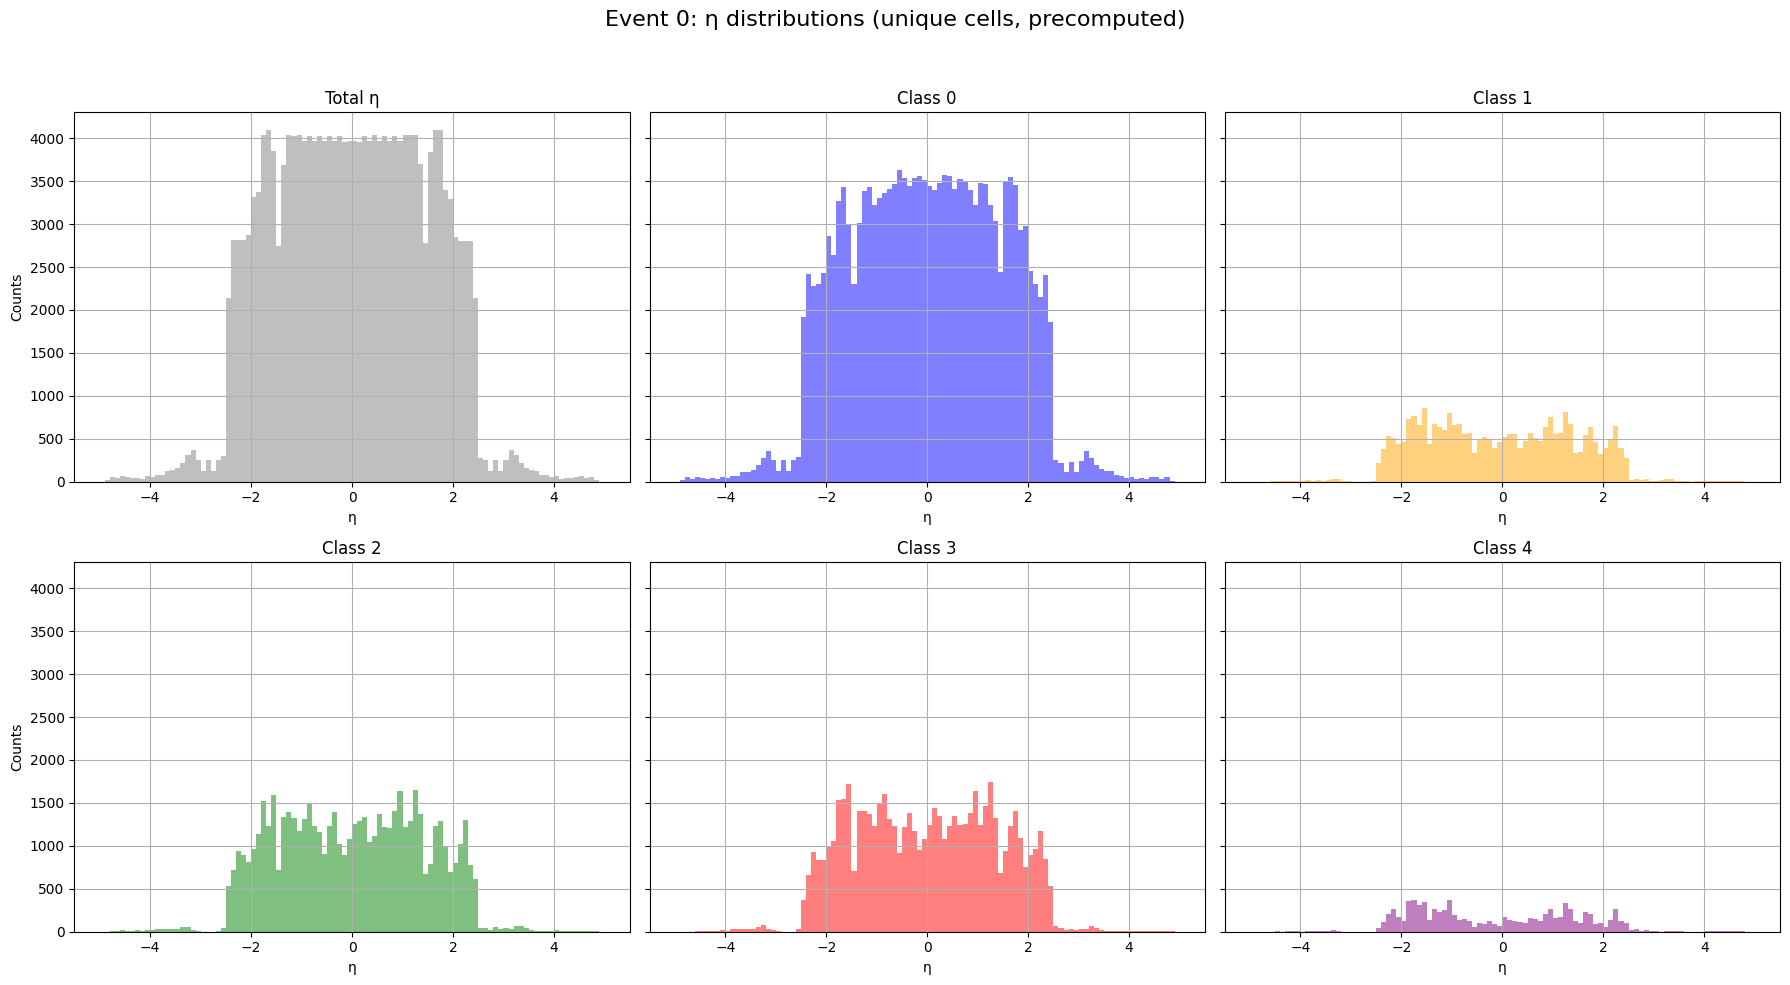

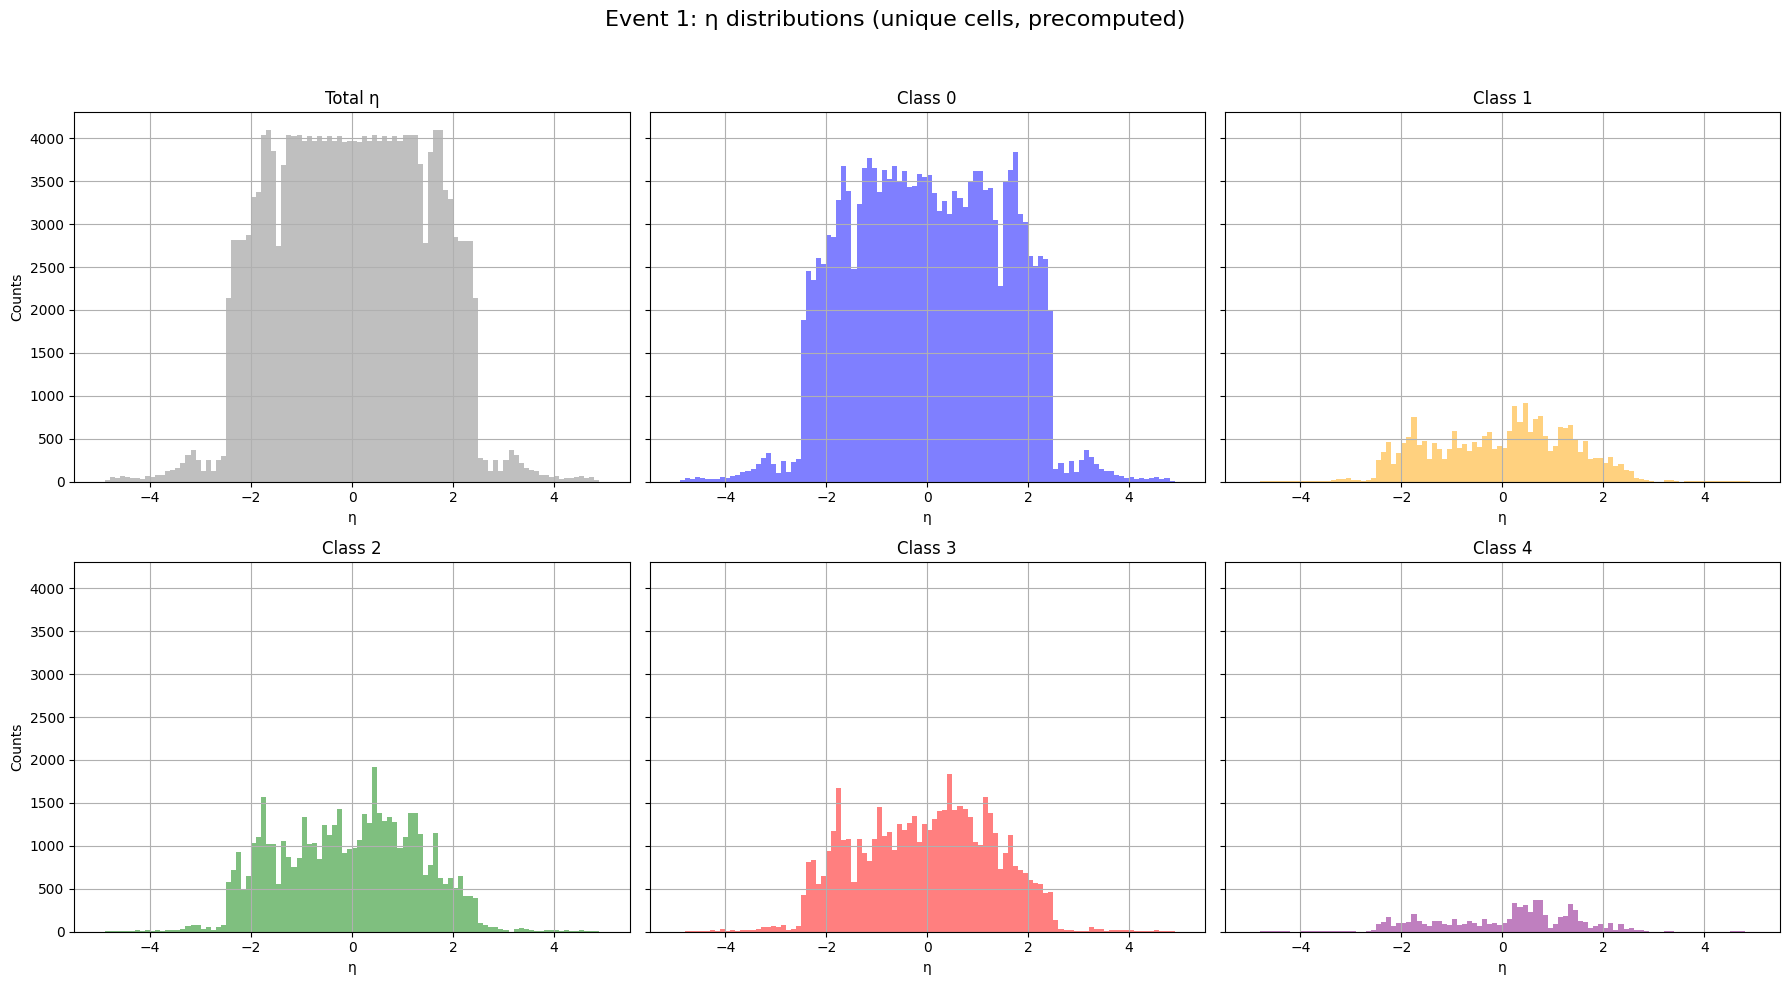

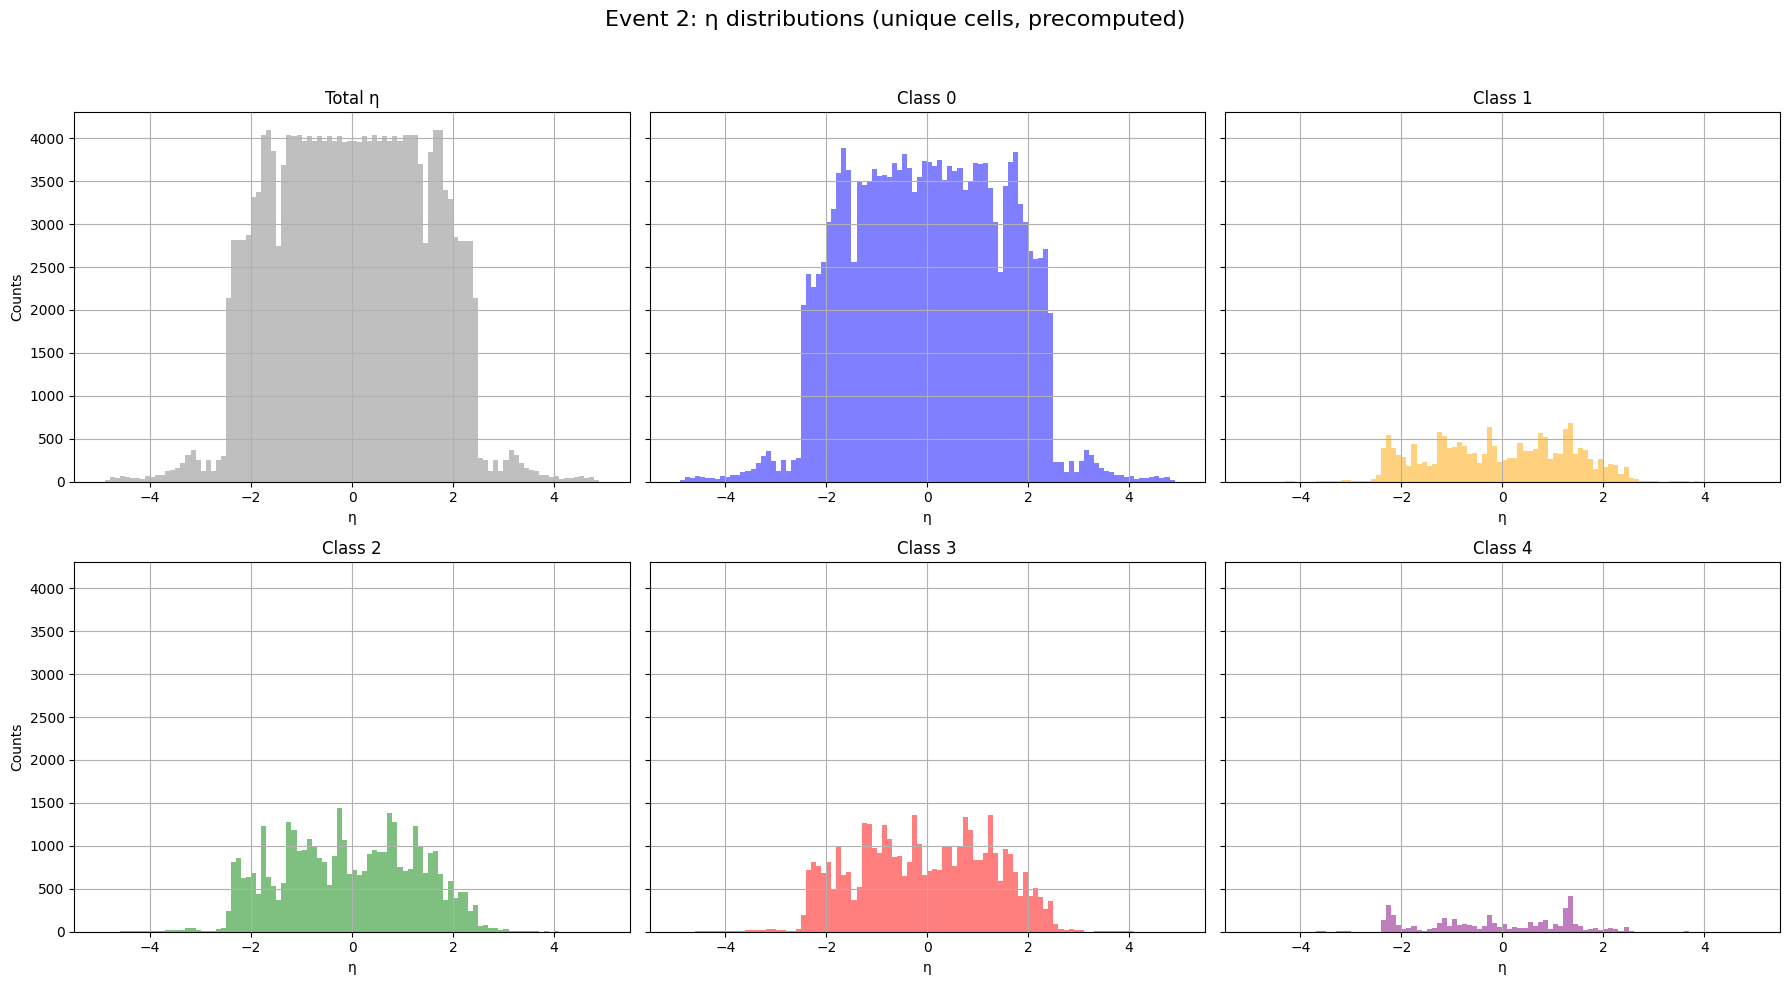

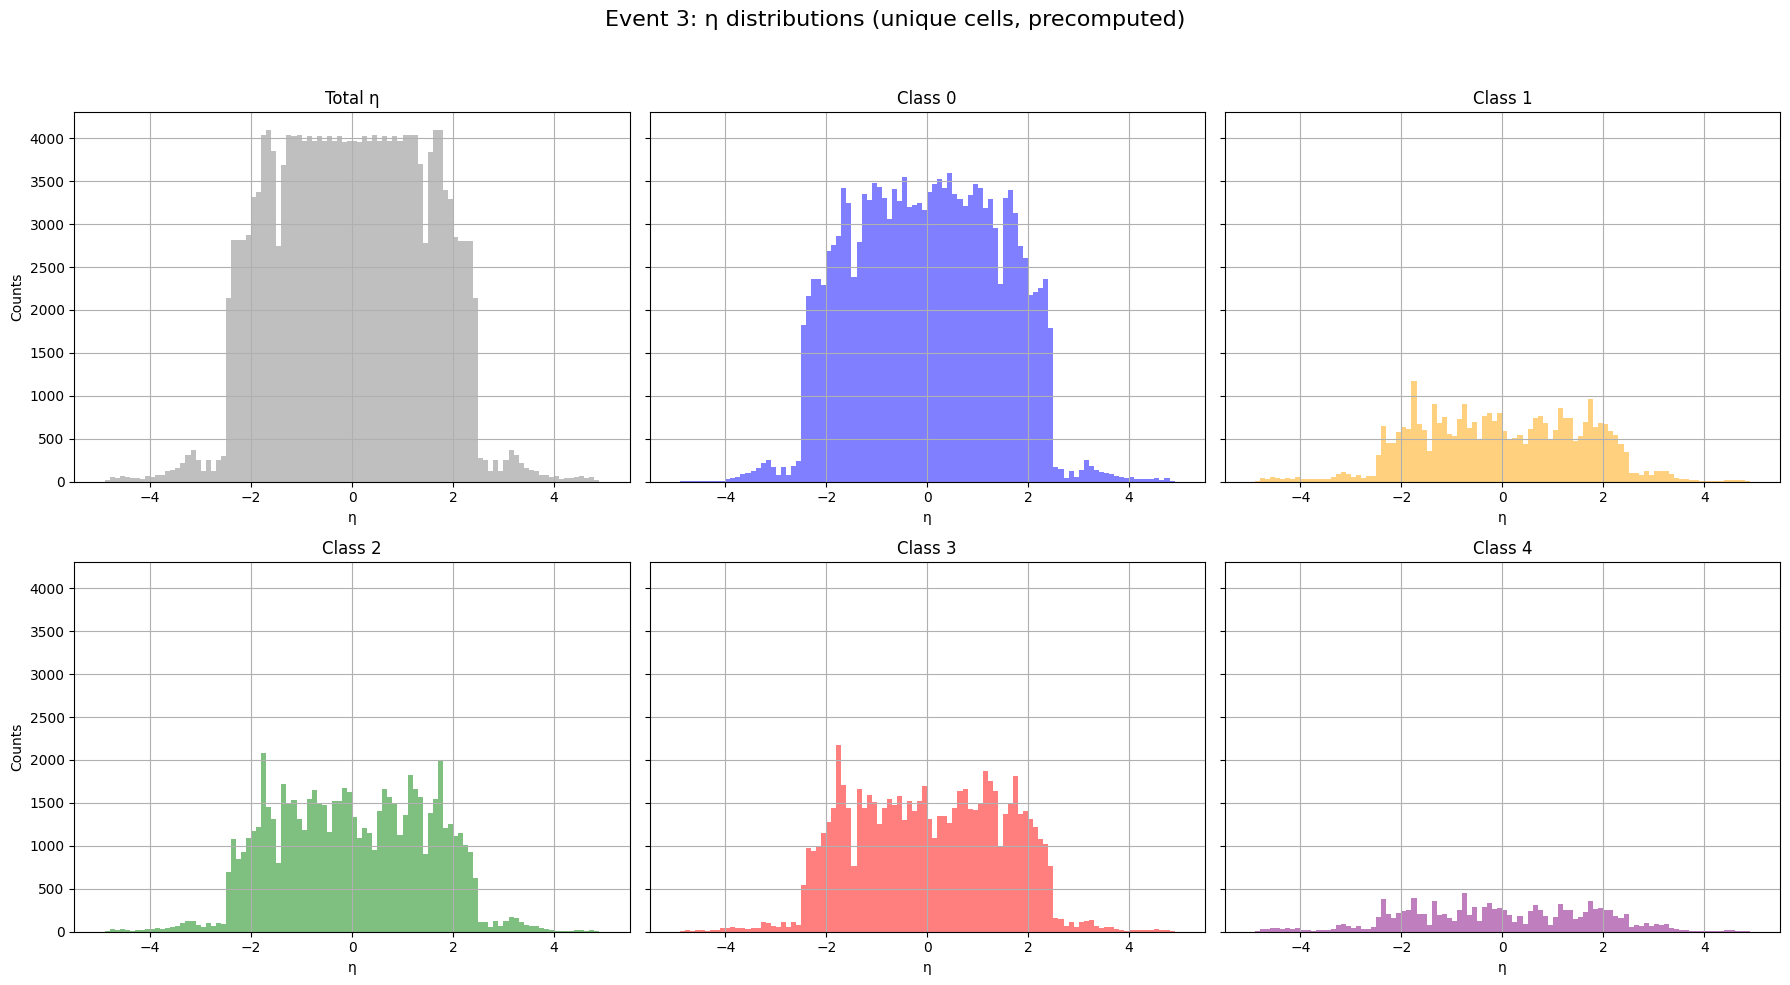

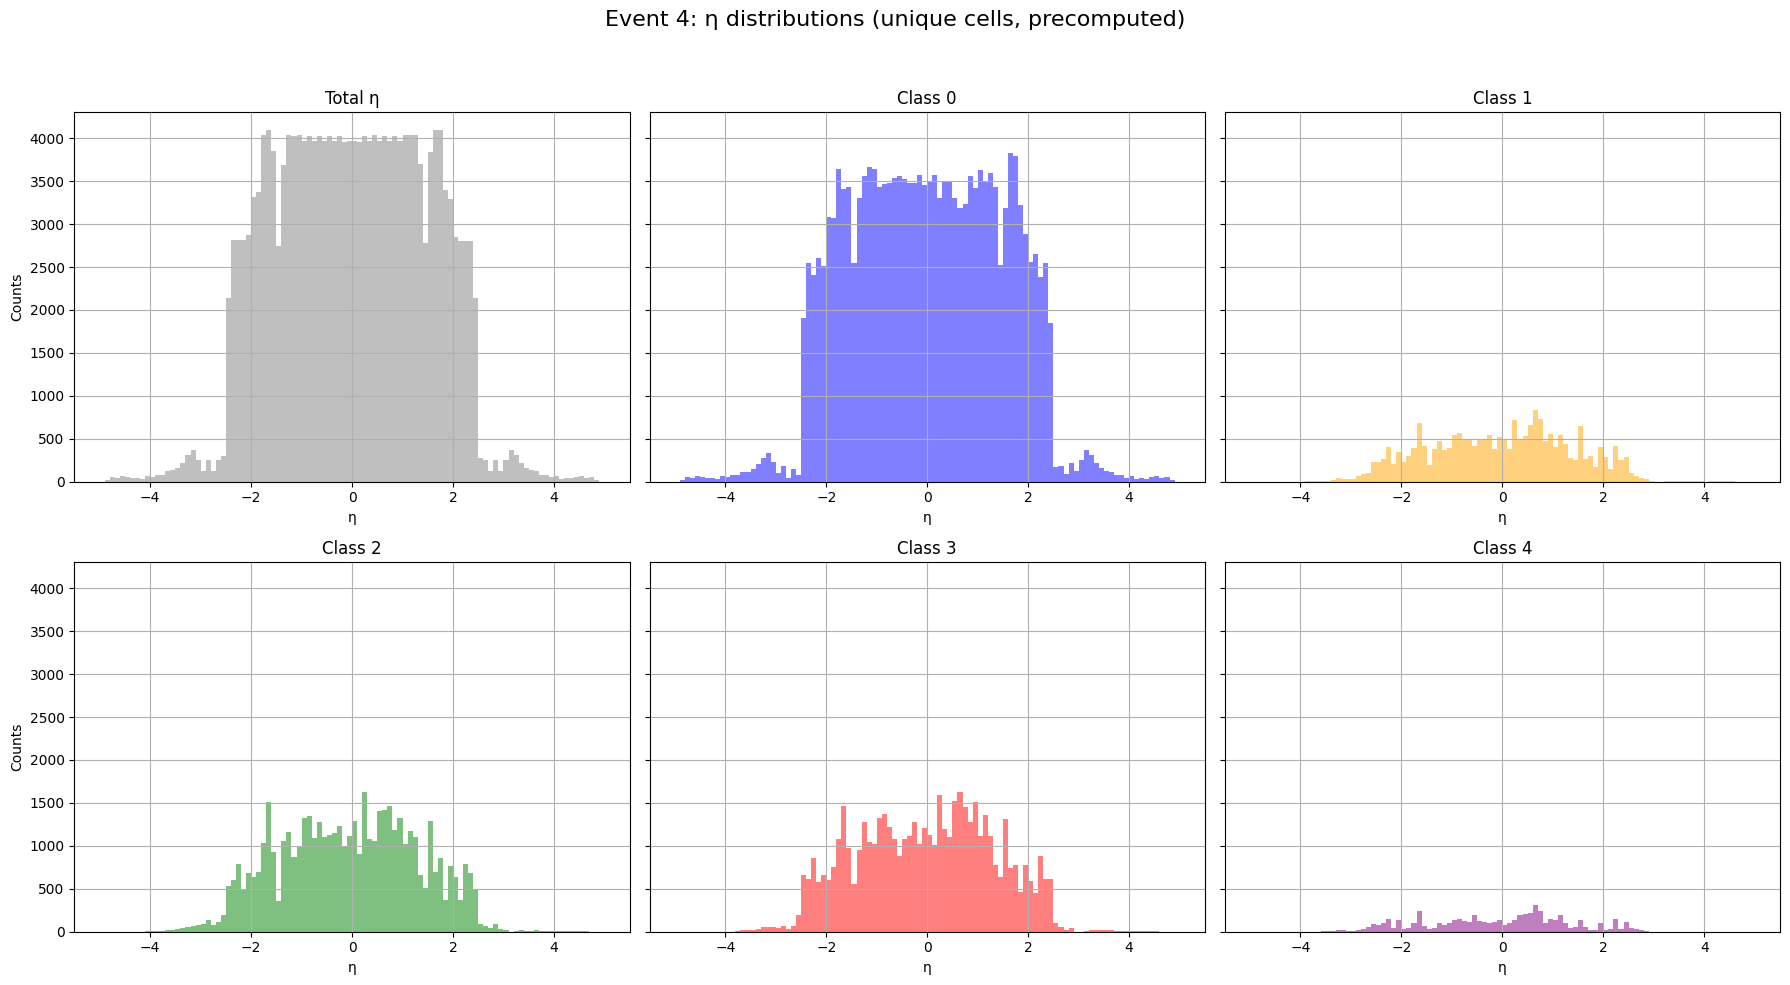

In [11]:
def plot_eta_distributions_unique(data, labels_for_neighbor_pairs, neighbor_pairs_array,
                                  num_events=3):
    """
    Plot η distributions overall and per class, for the first `num_events` events.
    Uses unique cells per class.
    """
    bins = 100
    colors = ['gray', 'blue', 'orange', 'green', 'red', 'purple']
    bin_edges = np.linspace(-5, 5, bins+1)

    total_events = len(data)  # auto-detect from dataset size
    num_events = min(num_events, total_events)

    # Precompute unique cells per class for all events
    unique_cells_per_class_per_event = []

    for evt in range(total_events):
        labels_evt = labels_for_neighbor_pairs[evt]
        pairs = neighbor_pairs_array
        eta_evt = data[f"data_{evt}"][:, 1]

        # Dictionary to store unique cell indices for each class
        unique_cells_dict = {}
        for cls in range(5):
            mask = labels_evt == cls
            cls_pairs = pairs[mask]
            cls_unique_cells = np.unique(cls_pairs.flatten())
            unique_cells_dict[cls] = cls_unique_cells

        unique_cells_per_class_per_event.append({
            "total": np.arange(eta_evt.shape[0]),  # all cells
            **unique_cells_dict
        })

    # --- Plotting loop ---
    for evt in range(num_events):
        eta_evt = data[f"data_{evt}"][:, 1]
        cells_dict = unique_cells_per_class_per_event[evt]

        # Compute histograms
        hist_total, _ = np.histogram(eta_evt[cells_dict["total"]], bins=bin_edges)
        hist_per_class = []
        for cls in range(5):
            hist_cls, _ = np.histogram(eta_evt[cells_dict[cls]], bins=bin_edges)
            hist_per_class.append(hist_cls)

        # --- Plot ---
        fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
        axes = axes.flatten()

        axes[0].bar((bin_edges[:-1] + bin_edges[1:])/2, hist_total, width=np.diff(bin_edges),
                    color=colors[0], alpha=0.5)
        axes[0].set_title("Total η")
        axes[0].set_xlabel("η")
        axes[0].grid(True)

        for cls in range(5):
            axes[cls+1].bar((bin_edges[:-1] + bin_edges[1:])/2, hist_per_class[cls],
                            width=np.diff(bin_edges), color=colors[cls+1], alpha=0.5)
            axes[cls+1].set_title(f"Class {cls}")
            axes[cls+1].set_xlabel("η")
            axes[cls+1].grid(True)

        axes[0].set_ylabel("Counts")
        axes[3].set_ylabel("Counts")

        plt.suptitle(f"Event {evt}: η distributions (unique cells, precomputed)", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

plot_eta_distributions_unique(data, labels_for_neighbor_pairs, neighbor_pairs_array, num_events=5)

In [12]:
class MultiClassBatchGenerator(IterableDataset):
    """
    Optimized batch generator for multi-class classification
    Precomputes samples to avoid redundant computation during training
    """
    
    def __init__(self, features_dict: Dict, neighbor_pairs: np.ndarray, labels: np.ndarray, 
                 class_counts: Dict, mode: str = 'train', is_bi_directional: bool = True, 
                 batch_size: int = 1, train_ratio: float = 0.7, padding: bool = False, 
                 with_labels: bool = False, padding_class: int = 0, debug: bool = False,
                 unscaled_data_dict: Optional[Dict] = None):
        
        self.debug = debug
        self.is_bi_directional = is_bi_directional
        self.batch_size = batch_size
        self.padding = padding
        self.with_labels = with_labels
        self.padding_class = padding_class

        # Scaled features (already normalized)
        self.features_dict = {
            k: torch.as_tensor(v, dtype=torch.float32)
            for k, v in features_dict.items()
        }

        # Unscaled features (for analysis/logging)
        if unscaled_data_dict is not None:
            self.unscaled_features_dict = self._precompute_unscaled_features(unscaled_data_dict)
        else:
            self.unscaled_features_dict = None

        # Labels and pairs
        self.neighbor_pairs = torch.tensor(neighbor_pairs, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.class_counts = class_counts

        # Train/test split
        num_events = len(features_dict)
        train_size = int(num_events * train_ratio)
        self.event_indices = list(range(train_size)) if mode == 'train' else list(range(train_size, num_events))

        # Precompute all samples during initialization
        self.precomputed_samples = self._precompute_all_samples()
        
        if self.debug:
            print(f"MultiClassBatchGenerator initialized with {len(self.precomputed_samples)} samples")
            print(f"Mode: {mode}, Events: {len(self.event_indices)}")

    def _precompute_unscaled_features(self, unscaled_data_dict: Dict) -> Dict:
        """Precompute unscaled features once during initialization"""
        unscaled_features = {}
        for k, v in unscaled_data_dict.items():
            tensor_v = torch.as_tensor(v, dtype=torch.float32)
            # If tensor has 4 columns, original code applies
            if tensor_v.shape[1] == 4:
                eta = tensor_v[:, 1]
                phi = torch.atan2(tensor_v[:, 3], tensor_v[:, 2])
                tensor_v = torch.cat([tensor_v[:, 0:1], eta[:, None], phi[:, None]], dim=1)
            elif tensor_v.shape[1] == 3:
                # Already [SNR, η, φ], so just transform η if needed
                eta = tensor_v[:, 1]
                phi = tensor_v[:, 2]  # φ is already present
                tensor_v = torch.stack([tensor_v[:, 0], eta, phi], dim=1)
            else:
                raise ValueError(f"Unexpected feature dimension {tensor_v.shape[1]} for key {k}")
            unscaled_features[k] = tensor_v
        return unscaled_features

    def _build_class_indices(self, event_id: int) -> Dict[int, torch.Tensor]:
        """Build class indices for a specific event"""
        class_indices = {}
        for cls in self.class_counts.keys():
            mask = self.labels[event_id] == cls
            class_indices[cls] = torch.where(mask)[0]
        return class_indices

    def _sample_edges(self, event_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """Sample edges for a specific event with class balancing"""
        class_indices = self._build_class_indices(event_id)
        sampled_indices = []
        padded_mask = []
        
        for cls, count in self.class_counts.items():
            indices = class_indices.get(cls, torch.tensor([], dtype=torch.long))
            if len(indices) > 0:
                selected = indices[torch.randperm(len(indices))[:min(count, len(indices))]]
                sampled_indices.append(selected)
                padded_mask.extend([True] * len(selected))

        sampled = torch.cat(sampled_indices) if sampled_indices else torch.tensor([], dtype=torch.long)

        if self.padding and len(sampled) < sum(self.class_counts.values()):
            pad_size = sum(self.class_counts.values()) - len(sampled)
            pad_indices = class_indices.get(self.padding_class, torch.tensor([], dtype=torch.long))
            if len(pad_indices) > 0:
                pad_indices = pad_indices[:pad_size]
                sampled = torch.cat([sampled, pad_indices])
                padded_mask.extend([False] * len(pad_indices))

        return sampled, torch.tensor(padded_mask, dtype=torch.bool)

    def _precompute_all_samples(self) -> List[Tuple]:
        """Precompute all samples to avoid computation during iteration"""
        samples = []
        
        for event_id in self.event_indices:
            edge_sample_idx, padded_mask = self._sample_edges(event_id)
            
            if len(edge_sample_idx) == 0:
                continue  # Skip events with no samples
                
            selected_pairs = self.neighbor_pairs[edge_sample_idx].T
            selected_labels = self.labels[event_id, edge_sample_idx].clone()

            if self.padding and not self.with_labels:
                selected_labels[~padded_mask] = self.padding_class

            x_scaled = self.features_dict[f"data_{event_id}"]
            x_unscaled = self.unscaled_features_dict.get(f"data_{event_id}") if self.unscaled_features_dict else None

            samples.append(
                (x_scaled, selected_pairs, selected_pairs.clone(), 
                 selected_labels.unsqueeze(1), x_unscaled)
            )
        
        return samples

    def __iter__(self):
        """Iterate through precomputed samples"""
        for sample in self.precomputed_samples:
            yield sample

    def __len__(self):
        return len(self.precomputed_samples)

    @staticmethod
    def collate_data(batch: List[Tuple]) -> Tuple:
        """Collate function for DataLoader"""
        x_list = [b[0] for b in batch]
        edge_index_list = [b[1] for b in batch]
        edge_index_out_list = [b[2] for b in batch]
        y_batch = torch.cat([b[3] for b in batch], dim=0)
    
        # Handle optional unscaled features
        if batch[0][4] is None:
            unscaled_list = None
        else:
            unscaled_list = [b[4] for b in batch]
    
        return x_list, edge_index_list, edge_index_out_list, y_batch, unscaled_list

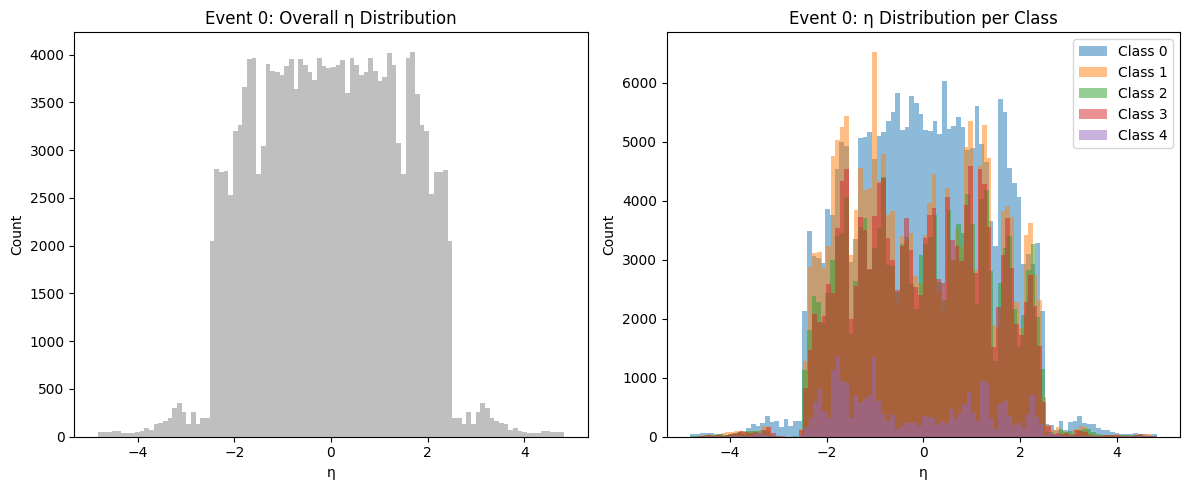

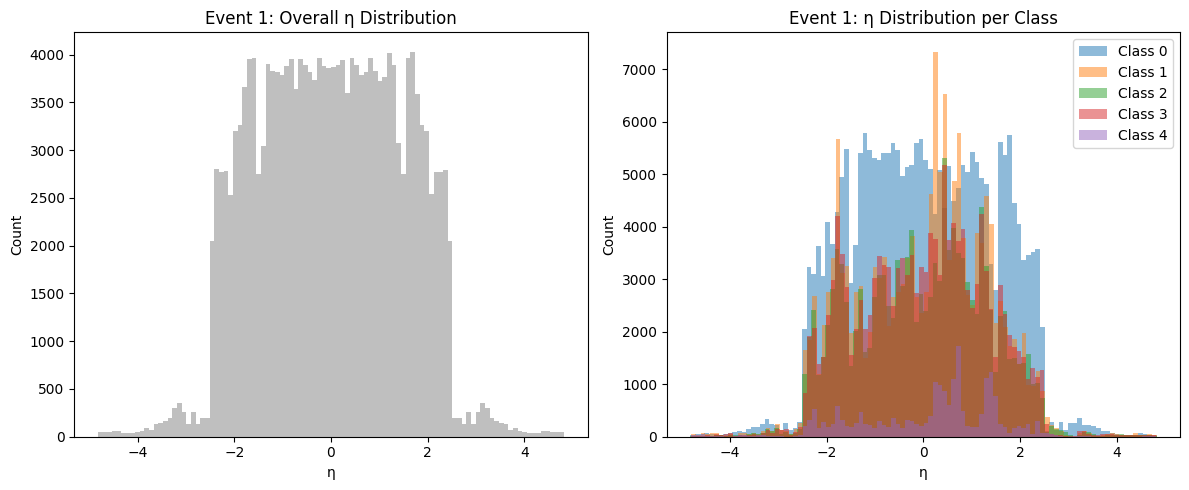

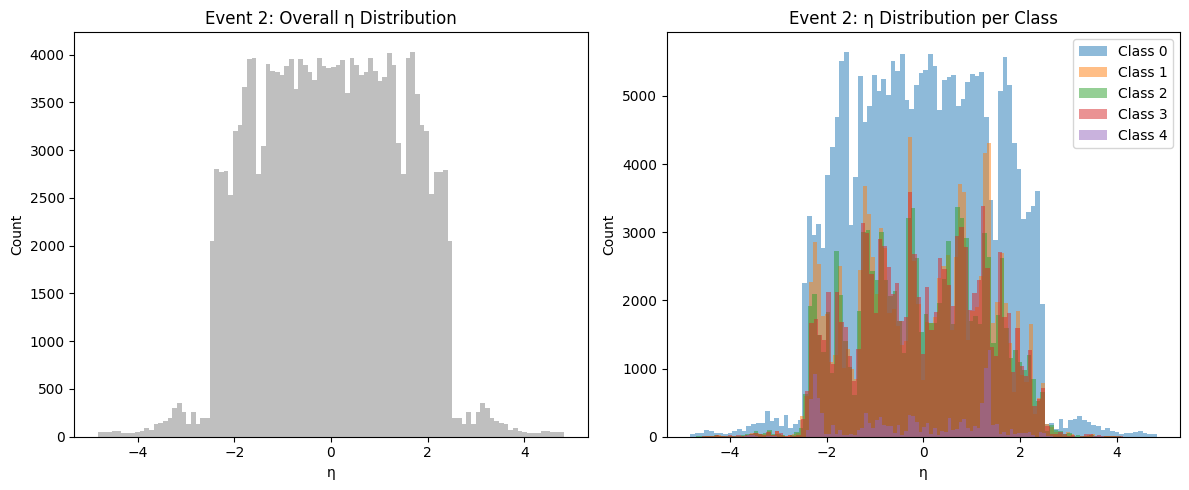

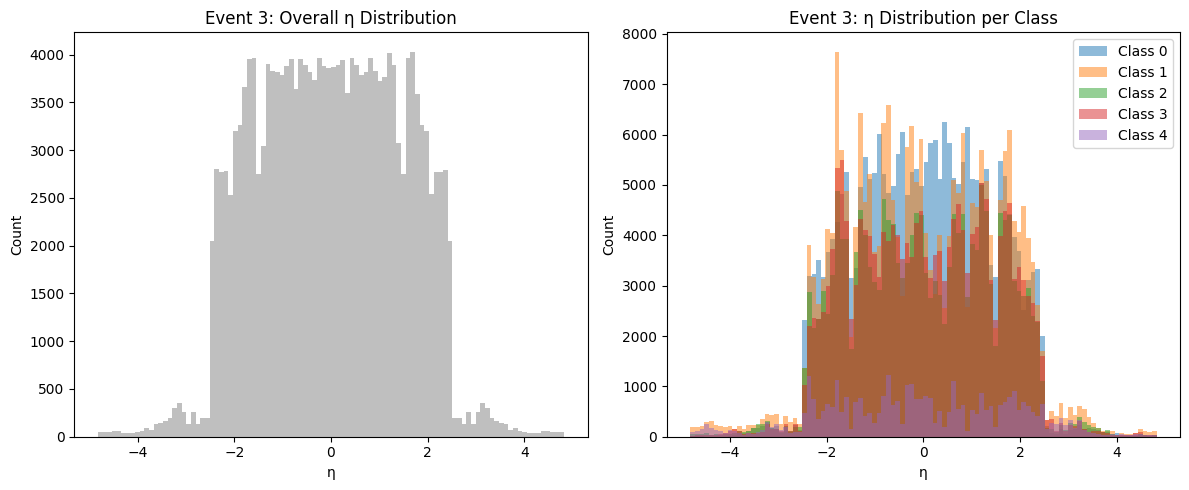

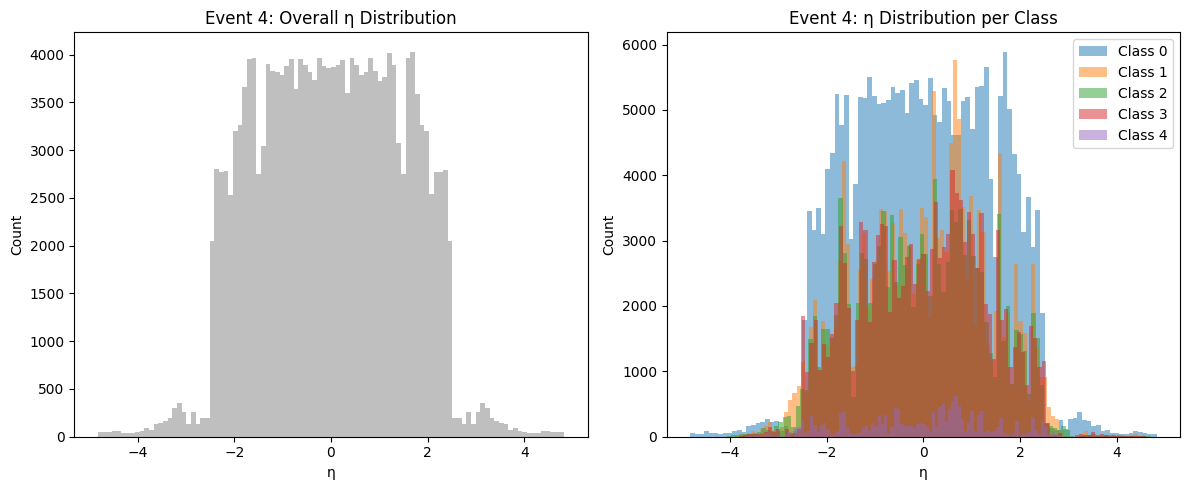

In [13]:
def plot_eta_distributions(generator: MultiClassBatchGenerator, num_events: int = 3):
    """
    Plot η distributions overall and per class for a few events
    """
    for i, (x_scaled, edge_index, edge_index_out, y, x_unscaled) in enumerate(generator):
        if i >= num_events:
            break

        if x_unscaled is None:
            print("⚠️ No unscaled features available for plotting.")
            return

        # η values per cell
        eta_values = x_unscaled[:, 1].numpy()

        # Neighbor pairs for this event
        pairs = edge_index.numpy().T  # shape (#pairs, 2)
        labels = y.squeeze().numpy()  # one label per pair

        # --- Plot overall eta distribution ---
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(eta_values, bins=100, alpha=0.5, color='gray')
        plt.title(f"Event {i}: Overall η Distribution")
        plt.xlabel("η")
        plt.ylabel("Count")

        # --- Plot eta per class ---
        plt.subplot(1, 2, 2)
        for cls in np.unique(labels):
            mask = labels == cls
            cls_pairs = pairs[mask]   # select pairs of this class

            # extract η of both cells in the pairs
            eta_cls = np.concatenate([
                eta_values[cls_pairs[:, 0]],
                eta_values[cls_pairs[:, 1]]
            ])

            plt.hist(eta_cls, bins=100, alpha=0.5, label=f"Class {cls}")
        
        plt.title(f"Event {i}: η Distribution per Class")
        plt.xlabel("η")
        plt.ylabel("Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

gen = MultiClassBatchGenerator(
    features_dict=scaled_data,
    neighbor_pairs=neighbor_pairs_array,
    labels=labels_for_neighbor_pairs,
    class_counts={0: 121318, 1: 1113965, 2: 90603, 3: 95347, 4: 20476},
    mode='train',
    unscaled_data_dict=data,
    debug=False
)

plot_eta_distributions(gen, num_events=5)

In [14]:
class MultiEdgeClassifier(nn.Module):
    """Graph Neural Network for edge classification"""
    
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, device: torch.device, 
                 num_layers: int = 6, layer_weights: bool = False, softmax: bool = False, 
                 debug: bool = False):
        super().__init__()
        self.device = device
        self.debug = debug
        self.layer_weights_enabled = layer_weights
        self.softmax = softmax
        self.num_layers = num_layers

        # Node embedding
        self.node_embedding = nn.Linear(input_dim, hidden_dim)
        
        # GCN layers with batch normalization
        self.convs = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers)])
        self.bns = nn.ModuleList([BatchNorm1d(hidden_dim) for _ in range(num_layers)])
        
        # Final classification layer
        self.fc = nn.Linear(2 * hidden_dim, output_dim)

        # Layer weights (optional)
        if self.layer_weights_enabled:
            self.layer_weights = nn.Parameter(torch.ones(num_layers))
        else:
            self.layer_weights = None

    def forward(self, x_list: List[torch.Tensor], edge_index_list: List[torch.Tensor], 
                edge_index_out_list: List[torch.Tensor], y_batch: Optional[torch.Tensor] = None) -> torch.Tensor:
        
        if self.debug:
            total_start = time.perf_counter()
            timings = {
                "weight_prep": 0.0,
                "move_to_device": 0.0,
                "node_embedding": 0.0,
                "layers": [0.0 for _ in range(self.num_layers)],
                "edge_repr": 0.0,
                "final_fc": 0.0
            }

        all_edge_reprs = []

        # Normalize weights if enabled
        if self.debug:
            t0 = time.perf_counter()
        if self.layer_weights_enabled:
            weights = torch.softmax(self.layer_weights, dim=0) if self.softmax else self.layer_weights
        else:
            weights = None
        if self.debug:
            timings["weight_prep"] += time.perf_counter() - t0

        # Process each graph in the batch
        for x, processed_edges, original_edges in zip(x_list, edge_index_list, edge_index_out_list):
            if self.debug:
                t1 = time.perf_counter()
            x = x.to(self.device, non_blocking=True)
            processed_edges = processed_edges.to(self.device, non_blocking=True)
            if self.debug:
                timings["move_to_device"] += time.perf_counter() - t1

            # Node embedding
            if self.debug:
                t2 = time.perf_counter()
            x_embed = self.node_embedding(x)
            if self.debug:
                timings["node_embedding"] += time.perf_counter() - t2

            # GCN layers with residual connections
            for i, (conv, bn) in enumerate(zip(self.convs, self.bns)):
                if self.debug:
                    t_layer = time.perf_counter()
                h = torch.relu(bn(conv(x_embed, processed_edges)))
                if self.layer_weights_enabled:
                    h = weights[i] * h
                x_embed = x_embed + h  # Residual connection
                if self.debug:
                    timings["layers"][i] += time.perf_counter() - t_layer

            # Build edge representations
            if self.debug:
                t3 = time.perf_counter()
            src, dst = original_edges[0], original_edges[1]
            edge_repr = torch.cat([x_embed[src], x_embed[dst]], dim=-1)
            all_edge_reprs.append(edge_repr)
            if self.debug:
                timings["edge_repr"] += time.perf_counter() - t3

        # Final classification
        if self.debug:
            t4 = time.perf_counter()
        out = self.fc(torch.cat(all_edge_reprs, dim=0))
        if self.debug:
            timings["final_fc"] += time.perf_counter() - t4
            total_time = time.perf_counter() - total_start

            print("\n[Forward Pass Timing Summary]")
            print(f"  Weight preparation: {timings['weight_prep']:.6f} s")
            print(f"  Move to device: {timings['move_to_device']:.6f} s")
            print(f"  Node embedding: {timings['node_embedding']:.6f} s")
            for i, t in enumerate(timings["layers"]):
                print(f"  Layer {i}: {t:.6f} s")
            print(f"  Edge representation build: {timings['edge_repr']:.6f} s")
            print(f"  Final FC: {timings['final_fc']:.6f} s")
            print(f"  TOTAL forward: {total_time:.6f} s\n")

        return out

def train_model(model: nn.Module, loader: DataLoader, optimizer: optim.Optimizer, 
                criterion: nn.Module, scaler: GradScaler, device: torch.device, 
                debug: bool = False) -> Dict[str, float]:
    """
    Optimized training function for single epoch
    """
    model.train()
    total_loss = correct = total = 0
    start_train = time.perf_counter()

    for batch_idx, (x_list, edge_idx_list, edge_idx_out_list, y_batch, unscaled_list) in enumerate(loader):
        if debug:
            start_batch = time.perf_counter()

        # Move batch to device (optimized with list comprehensions)
        x_list = [x.to(device, non_blocking=True) for x in x_list]
        edge_idx_list = [e.to(device, non_blocking=True) for e in edge_idx_list]
        edge_idx_out_list = [e.to(device, non_blocking=True) for e in edge_idx_out_list]
        y_batch = y_batch.to(device, non_blocking=True).squeeze(1)

        optimizer.zero_grad(set_to_none=True)  # Faster zero_grad

        # Forward + loss with mixed precision
        with torch.amp.autocast(device_type="cuda"):
            scores = model(x_list, edge_idx_list, edge_idx_out_list)
            loss = criterion(scores, y_batch)

        # Backward + optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Metrics
        total_loss += loss.item() * len(y_batch)
        preds = scores.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += len(y_batch)

        if debug and batch_idx % 10 == 0:  # Reduced debug output frequency
            batch_time = time.perf_counter() - start_batch
            print(f"Batch {batch_idx+1}: loss={loss.item():.4f}, time={batch_time:.3f}s")

    epoch_time = time.perf_counter() - start_train
    
    if debug:
        print(f"Training epoch completed in {epoch_time:.2f}s")

    return {
        'loss': total_loss / total if total > 0 else 0,
        'acc': correct / total if total > 0 else 0
    }

def test_model(model: nn.Module, loader: DataLoader, criterion: nn.Module, 
               device: torch.device, debug: bool = False) -> Dict[str, float]:
    """
    Optimized testing function
    """
    model.eval()
    total_loss = correct = total = 0
    start_test = time.perf_counter()

    with torch.no_grad():
        for batch_idx, (x_list, edge_idx_list, edge_idx_out_list, y_batch, unscaled_list) in enumerate(loader):
            # Move batch to device
            x_list = [x.to(device, non_blocking=True) for x in x_list]
            edge_idx_list = [e.to(device, non_blocking=True) for e in edge_idx_list]
            edge_idx_out_list = [e.to(device, non_blocking=True) for e in edge_idx_out_list]
            y_batch = y_batch.to(device, non_blocking=True).squeeze(1)

            # Forward + loss with mixed precision
            with torch.amp.autocast(device_type="cuda"):
                scores = model(x_list, edge_idx_list, edge_idx_out_list)
                loss = criterion(scores, y_batch)

            # Metrics
            total_loss += loss.item() * len(y_batch)
            preds = scores.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += len(y_batch)

    test_time = time.perf_counter() - start_test
    
    if debug:
        print(f"Testing completed in {test_time:.2f}s")

    return {
        'loss': total_loss / total if total > 0 else 0,
        'acc': correct / total if total > 0 else 0
    }

@torch.no_grad()
def run_inference(model, loader, device, unscaled_data_dict=None, debug=False):
    """
    Fixed inference function for (187650, 3) data format
    """
    model.eval()
    if debug:
        start_time = time.perf_counter()

    # Storage
    all_preds, all_scores, all_labels = [], [], []
    all_features_i, all_features_j = [], []
    all_features_i_unscaled, all_features_j_unscaled = [], []
    all_neighbor_pairs = []

    has_unscaled = unscaled_data_dict is not None

    for batch_idx, (x_list, edge_index_list, edge_index_out_list, y_batch, unscaled_list) in enumerate(loader):
        if debug and batch_idx % 10 == 0:
            print(f"Processing batch {batch_idx+1}")
        
        # Move to device
        x_list = [x.to(device) for x in x_list]
        edge_index_list = [e.to(device) for e in edge_index_list]
        edge_index_out_list = [e.to(device) for e in edge_index_out_list]
        if y_batch is not None:
            y_batch = y_batch.to(device)

        # Forward pass
        out = model(x_list, edge_index_list, edge_index_out_list, y_batch)
        preds = out.argmax(dim=1).cpu()
        scores = torch.softmax(out, dim=1).cpu()
        all_preds.append(preds)
        all_scores.append(scores)
        if y_batch is not None:
            all_labels.append(y_batch.cpu())

        # For each graph in the batch (batch_size=1 typically)
        for i, (x, edges_out) in enumerate(zip(x_list, edge_index_out_list)):
            src_nodes, dst_nodes = edges_out[0], edges_out[1]
            
            # Scaled features
            feats_i_scaled = x[src_nodes].cpu()
            feats_j_scaled = x[dst_nodes].cpu()
            all_features_i.append(feats_i_scaled)
            all_features_j.append(feats_j_scaled)
            
            # Neighbor pairs
            all_neighbor_pairs.append(torch.stack([src_nodes.cpu(), dst_nodes.cpu()], dim=1))
            
            # Unscaled features - FIXED
            if has_unscaled and unscaled_list is not None and i < len(unscaled_list):
                unscaled_x = unscaled_list[i]  # This is the unscaled data for this event
                feats_i_unscaled = unscaled_x[src_nodes.cpu()]
                feats_j_unscaled = unscaled_x[dst_nodes.cpu()]
                all_features_i_unscaled.append(feats_i_unscaled)
                all_features_j_unscaled.append(feats_j_unscaled)

    # Concatenate results
    results = {
        "preds": torch.cat(all_preds).numpy() if all_preds else np.array([]),
        "scores": torch.cat(all_scores).numpy() if all_scores else np.array([]),
        "labels": torch.cat(all_labels).numpy() if all_labels else None,
        "features_i": torch.cat(all_features_i).numpy() if all_features_i else np.array([]),
        "features_j": torch.cat(all_features_j).numpy() if all_features_j else np.array([]),
        "neighbor_pairs": torch.cat(all_neighbor_pairs).numpy() if all_neighbor_pairs else np.array([]),
    }

    if has_unscaled and all_features_i_unscaled:
        results["features_i_unscaled"] = torch.cat(all_features_i_unscaled).numpy()
        results["features_j_unscaled"] = torch.cat(all_features_j_unscaled).numpy()

    if debug:
        elapsed = time.perf_counter() - start_time
        print(f"[DEBUG] Inference completed in {elapsed:.2f} sec for {batch_idx+1} batches.")
        if "features_i_unscaled" in results:
            print(f"Unscaled features shape: {results['features_i_unscaled'].shape}")

    return results

def run_model(model: nn.Module, batch_size: int, save_dir: str, best_model_name: str,
              train_generator_class: type, test_generator_class: type,
              train_generator_kwargs: Dict, test_generator_kwargs: Dict,
              epochs: int, device: torch.device, optimizer: optim.Optimizer, 
              criterion: nn.Module, unscaled_data_dict: Optional[Dict] = None, 
              lr: float = 1e-3, resume: bool = True, patience: int = 10, 
              delta: float = 0.0001, debug: bool = False) -> Tuple[Dict, nn.Module, str]:
    """
    Training loop with per-epoch checkpoints and final best model inference.
    """

    # Make save directory
    if not debug:
        os.makedirs(save_dir, exist_ok=True)
    
    model_path = os.path.join(save_dir, best_model_name)
    best_model_path = os.path.join(save_dir, f"best_{best_model_name}")
    metrics_path = os.path.splitext(model_path)[0] + ".pkl"

    # Initialize training state
    start_epoch = 1
    best_test_acc = 0.0
    best_test_loss = float("inf")
    best_epoch = 0
    total_time_trained = 0.0
    scaler = torch.amp.GradScaler(device="cuda")

    # Resume if checkpoint exists
    if resume:
        checkpoint_result = find_latest_checkpoint(save_dir, best_model_name)
        if checkpoint_result:
            resumed_epoch, latest_checkpoint_path = checkpoint_result
            checkpoint = torch.load(latest_checkpoint_path, map_location=device, weights_only=True)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scaler.load_state_dict(checkpoint['scaler_state_dict'])
            start_epoch = resumed_epoch + 1
            if not debug:
                print(f"Resuming from checkpoint: {latest_checkpoint_path} (epoch {resumed_epoch})")
            if os.path.exists(metrics_path):
                try:
                    with open(metrics_path, 'rb') as f:
                        metrics = pickle.load(f)
                    best_test_acc = float(np.max(metrics.get('test_acc', [0.0])))
                    best_epoch = int(np.argmax(metrics.get('test_acc', [0.0]))) + 1
                    total_time_trained = metrics.get('total_time', 0.0)
                except:
                    metrics = {}
            else:
                metrics = {}
        else:
            if not debug:
                print("No previous checkpoint found. Starting from scratch.")
            metrics = {}
    else:
        metrics = {}

    # Initialize metrics
    metrics.update({
        'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [],
        'epoch_times': [], 'best_epoch': best_epoch,
        'best_test_acc': best_test_acc, 'best_test_loss': best_test_loss,
        'total_time': total_time_trained, 'time_per_epoch': 0.0
    })

    # Create DataLoaders once
    train_loader = DataLoader(
        train_generator_class(**train_generator_kwargs),
        batch_size=batch_size,
        collate_fn=MultiClassBatchGenerator.collate_data,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_generator_class(**test_generator_kwargs),
        batch_size=batch_size,
        collate_fn=MultiClassBatchGenerator.collate_data,
        pin_memory=True
    )

    early_stopping_counter = 0
    
    # Epoch loop
    for epoch in range(start_epoch, epochs + 1):
        epoch_start_time = time.perf_counter()
    
        # Train and test
        train_results = train_model(model, train_loader, optimizer, criterion, scaler, device, debug=debug)
        test_results = test_model(model, test_loader, criterion, device, debug=debug)
    
        # Metrics update
        epoch_time = time.perf_counter() - epoch_start_time
        metrics['epoch_times'].append(epoch_time)
        metrics['train_loss'].append(train_results['loss'])
        metrics['test_loss'].append(test_results['loss'])
        metrics['train_acc'].append(train_results['acc'])
        metrics['test_acc'].append(test_results['acc'])
    
        # Current test loss
        current_test_loss = test_results['loss']
    
        # Check for real improvement
        if current_test_loss < best_test_loss:
            best_test_loss = current_test_loss
            best_test_acc = test_results['acc']
            best_epoch = epoch
            metrics['best_epoch'] = best_epoch
            metrics['best_test_acc'] = best_test_acc
            metrics['best_test_loss'] = best_test_loss
            early_stopping_counter = 0  # reset counter on real improvement
    
            # Save best model
            if not debug:
                torch.save({
                    'epoch': best_epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict(),
                    'best_test_acc': best_test_acc,
                    'best_test_loss': best_test_loss
                }, best_model_path)
        else:
            # Increment counter only if improvement < delta
            if current_test_loss > best_test_loss - delta:
                early_stopping_counter += 1
    
        # Save checkpoint every epoch
        if not debug:
            checkpoint_path = os.path.join(save_dir, f"{os.path.splitext(best_model_name)[0]}_epoch{epoch}.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
            }, checkpoint_path)
    
        # Print progress
        if debug or epoch % 5 == 0:
            print(f"GPU {device.index if hasattr(device, 'index') else 'CPU'} | "
                  f"Time {epoch_time:.1f}s | Best Test Acc: {best_test_acc:.4f}\n"
                  f"Epoch {epoch:03d}/{epochs} | "
                  f"Train Loss: {train_results['loss']:.4f} | Train Acc: {train_results['acc']:.4f} | "
                  f"Test Loss: {test_results['loss']:.4f} | Test Acc: {test_results['acc']:.4f}")
    
        # Early stopping check
        if early_stopping_counter >= patience:
            if not debug:
                print(f"\nEarly stopping triggered at epoch {epoch}!")
            break

    # Update total time
    metrics['total_time'] = total_time_trained + sum(metrics['epoch_times'])
    metrics['time_per_epoch'] = np.mean(metrics['epoch_times']) if metrics['epoch_times'] else 0

    # Load best model and run final inference
    if not debug:
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        final_results = run_inference(model, test_loader, device, debug=debug)

        final_metrics = {
            **metrics,
            'final_preds': final_results['preds'],
            'final_scores': final_results['scores'],
            'final_labels': final_results['labels'],
            'final_features_i': final_results['features_i'],
            'final_features_j': final_results['features_j'],
            'final_neighbor_pairs': final_results['neighbor_pairs']
        }
        if 'features_i_unscaled' in final_results:
            final_metrics['final_features_i_unscaled'] = final_results['features_i_unscaled']
            final_metrics['final_features_j_unscaled'] = final_results['features_j_unscaled']

        save_data_pickle(os.path.basename(metrics_path), os.path.dirname(metrics_path), final_metrics)
        total_min, total_sec = divmod(metrics['total_time'], 60)
        print(f"\nTraining complete in {int(total_min)}m {total_sec:.1f}s")
        print(f"Best model at epoch {best_epoch} with test accuracy: {best_test_acc:.4f}")

    return final_metrics, model, best_model_path

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = 3
hidden_dim = 128
output_dim = 5 
num_layers = 6

model = MultiEdgeClassifier(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    device=device,
    num_layers=num_layers,
    softmax=False,
    layer_weights=False,
    debug=False
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler(device=device)

# Generator setup
gen_kwargs = {
    'features_dict': scaled_data,
    'neighbor_pairs': neighbor_pairs_array,
    'labels': labels_for_neighbor_pairs,
    'class_counts': {0: 121318, 1: 1113965, 2: 90603, 3: 95347, 4: 20476},
    'batch_size': 1,
    'unscaled_data_dict': data,
    'debug': False
}
        
train_kwargs = {**gen_kwargs, 'mode': 'train'}

train_loader = DataLoader(
    MultiClassBatchGenerator(**train_kwargs),
    batch_size=1,
    collate_fn=MultiClassBatchGenerator.collate_data,
    pin_memory=True
)

train_model(model=model, loader=train_loader, optimizer=optimizer, criterion=criterion, scaler=scaler, device=device, debug=True)
# Generator kwargs for test set
test_kwargs = {**gen_kwargs, 'mode': 'test'}

test_loader = DataLoader(
    MultiClassBatchGenerator(**test_kwargs),
    batch_size=1,
    collate_fn=MultiClassBatchGenerator.collate_data,
    pin_memory=True
)

# Run inference
results = run_inference(model, test_loader, device, unscaled_data_dict=data, debug=True)

Batch 1: loss=2.1343, time=0.899s
Batch 11: loss=0.9459, time=0.088s
Batch 21: loss=1.1956, time=0.103s
Batch 31: loss=0.8180, time=0.094s
Batch 41: loss=0.6789, time=0.093s
Batch 51: loss=0.6778, time=0.087s
Batch 61: loss=0.6322, time=0.095s
Batch 71: loss=0.5483, time=0.089s
Batch 81: loss=0.6602, time=0.099s
Batch 91: loss=0.5665, time=0.091s
Batch 101: loss=0.7224, time=0.107s
Batch 111: loss=0.6159, time=0.100s
Batch 121: loss=0.5209, time=0.093s
Batch 131: loss=0.6141, time=0.103s
Batch 141: loss=0.6542, time=0.111s
Batch 151: loss=0.6067, time=0.104s
Batch 161: loss=0.6902, time=0.099s
Batch 171: loss=0.5622, time=0.105s
Batch 181: loss=0.6226, time=0.105s
Batch 191: loss=0.5211, time=0.095s
Batch 201: loss=0.6484, time=0.104s
Batch 211: loss=0.3569, time=0.074s
Batch 221: loss=0.3258, time=0.072s
Batch 231: loss=0.2090, time=0.069s
Batch 241: loss=0.2844, time=0.075s
Batch 251: loss=0.3097, time=0.070s
Batch 261: loss=0.2123, time=0.069s
Batch 271: loss=0.2547, time=0.075s
Bat

Total edges: 65,878,094
Labels available: True
Unique labels: [0 1 2 3 4]

Processing event 0
Event 0: 2 edges
eta_i_evt shape: (2,)
labels_evt shape: (2,)
Unique labels in event: [0]
η range: [-2.450, 1.175]
Class 0: 2 edges


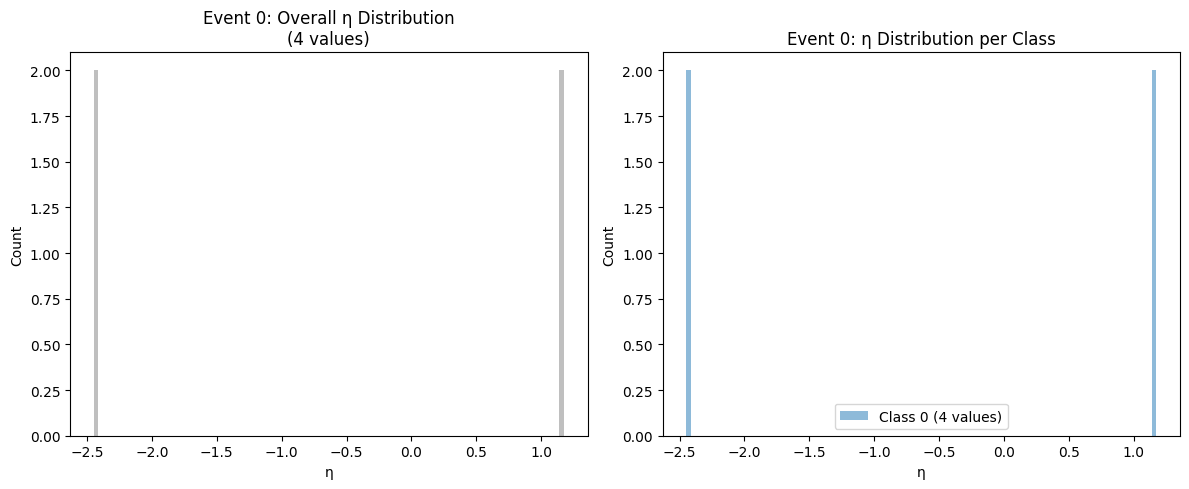


Processing event 1
Event 1: 2 edges
eta_i_evt shape: (2,)
labels_evt shape: (2,)
Unique labels in event: [0]
η range: [1.286, 2.424]
Class 0: 2 edges


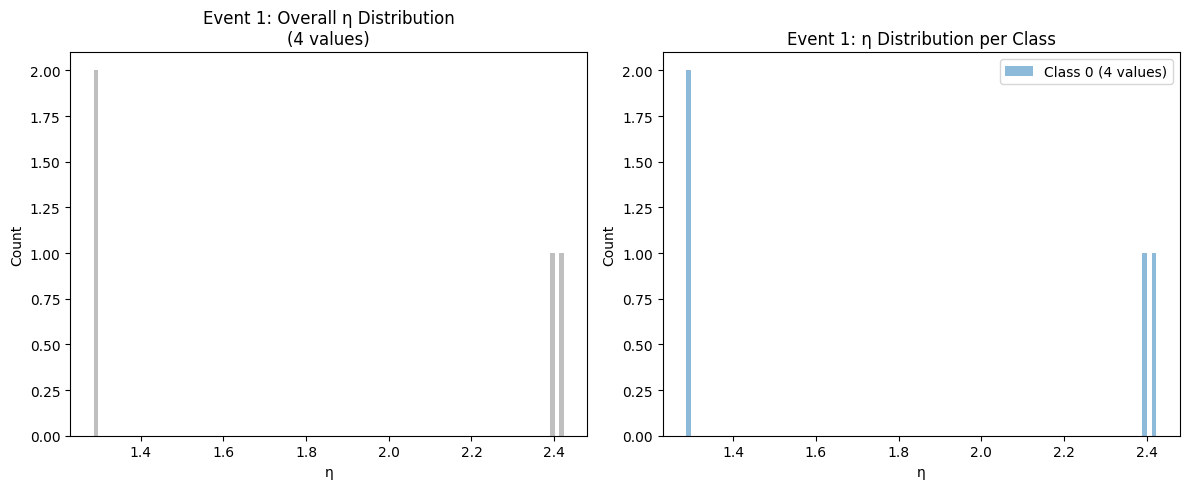


Processing event 2
Event 2: 2 edges
eta_i_evt shape: (2,)
labels_evt shape: (2,)
Unique labels in event: [0]
η range: [1.104, 2.389]
Class 0: 2 edges


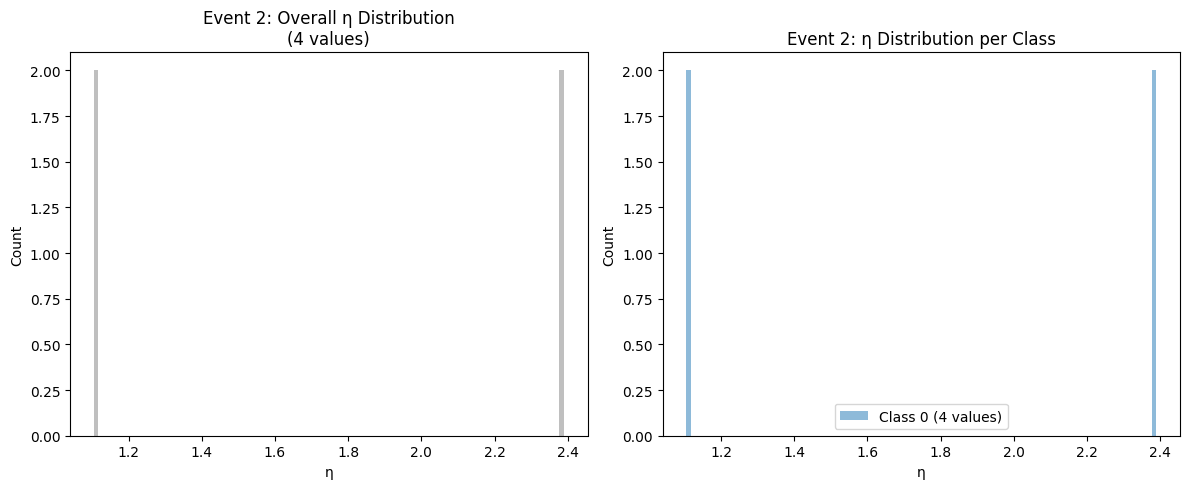


Processing event 3
Event 3: 2 edges
eta_i_evt shape: (2,)
labels_evt shape: (2,)
Unique labels in event: [0]
η range: [-1.749, -1.702]
Class 0: 2 edges


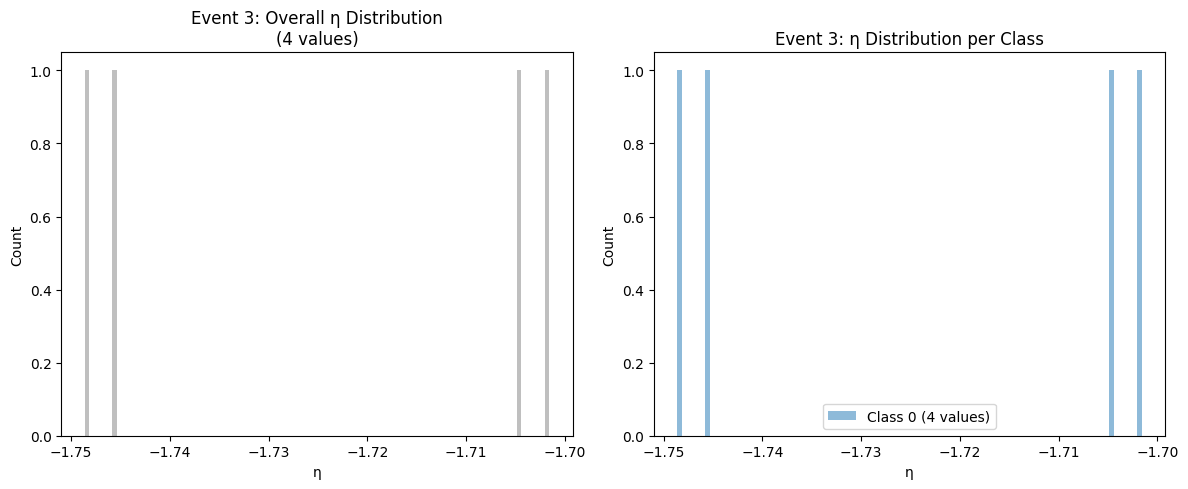


Processing event 4
Event 4: 2 edges
eta_i_evt shape: (2,)
labels_evt shape: (2,)
Unique labels in event: [0]
η range: [-0.311, 0.377]
Class 0: 2 edges


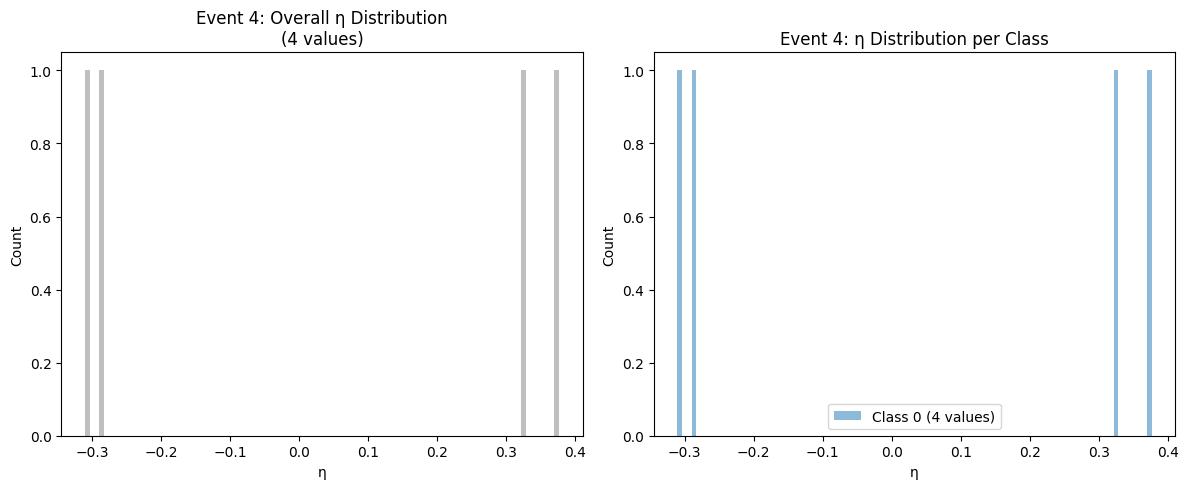

In [16]:
def plot_eta_distributions_from_results(results, num_events=3):
    """
    Plot η distributions overall and per class for a few events, using run_inference results.
    """
    # Use the correct key names from the fixed inference function
    if "features_i_unscaled" in results:
        eta_i = results["features_i_unscaled"][:, 1]  # η values from unscaled features
        eta_j = results["features_j_unscaled"][:, 1]
    else:
        eta_i = results["features_i"][:, 1]  # η values from scaled features
        eta_j = results["features_j"][:, 1]
    
    neighbor_pairs = results["neighbor_pairs"]
    labels = results["labels"] if "labels" in results else None

    print(f"Total edges: {len(eta_i):,}")
    print(f"Labels available: {labels is not None}")
    if labels is not None:
        # Convert 2D labels to 1D
        labels_1d = labels.squeeze()
        print(f"Unique labels: {np.unique(labels_1d)}")

    # Loop over events - since we have batch_size=1, each batch is one event
    for evt in range(min(num_events, len(neighbor_pairs))):
        print(f"\nProcessing event {evt}")
        
        # For batch_size=1, each batch is one event
        # Get the indices for this event's edges
        event_start = 0
        for i in range(evt):
            event_start += len(neighbor_pairs[i]) if i < len(neighbor_pairs) else 0
        
        event_end = event_start + len(neighbor_pairs[evt])
        
        # Extract data for this event
        eta_i_evt = eta_i[event_start:event_end]
        eta_j_evt = eta_j[event_start:event_end]
        
        if labels is not None:
            labels_evt = labels_1d[event_start:event_end]  # Use the 1D version
        else:
            labels_evt = None

        print(f"Event {evt}: {len(eta_i_evt)} edges")
        print(f"eta_i_evt shape: {eta_i_evt.shape}")
        if labels_evt is not None:
            print(f"labels_evt shape: {labels_evt.shape}")
            print(f"Unique labels in event: {np.unique(labels_evt)}")

        # gather η values for overall distribution
        eta_evt = np.concatenate([eta_i_evt, eta_j_evt])

        print(f"η range: [{eta_evt.min():.3f}, {eta_evt.max():.3f}]")

        # --- Plot overall eta distribution ---
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(eta_evt, bins=100, alpha=0.5, color='gray')
        plt.title(f"Event {evt}: Overall η Distribution\n({len(eta_evt)} values)")
        plt.xlabel("η")
        plt.ylabel("Count")

        # --- Plot eta per class ---
        plt.subplot(1, 2, 2)
        if labels_evt is not None and len(labels_evt) > 0:
            
            for cls in np.unique(labels_evt):
                cls_mask = labels_evt == cls
                print(f"Class {cls}: {cls_mask.sum()} edges")
                
                # Since eta_i_evt and eta_j_evt are 1D arrays, we can index directly
                eta_cls_i = eta_i_evt[cls_mask]
                eta_cls_j = eta_j_evt[cls_mask]
                eta_cls = np.concatenate([eta_cls_i, eta_cls_j])
                
                if len(eta_cls) > 0:  # Only plot if we have data
                    plt.hist(eta_cls, bins=100, alpha=0.5, label=f"Class {cls} ({len(eta_cls)} values)")
            
            plt.title(f"Event {evt}: η Distribution per Class")
            plt.xlabel("η")
            plt.ylabel("Count")
            plt.legend()
        else:
            plt.text(0.5, 0.5, "No label data available", 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes)
            plt.title(f"Event {evt}: No Label Data")
        
        plt.tight_layout()
        plt.show()

# Now run it
plot_eta_distributions_from_results(results, num_events=5)

Processing event 0
Event 0: 385199 edges
Predicted classes: [0 1 2 3 4]
Class counts: [130394 101792  76064  76948      1]


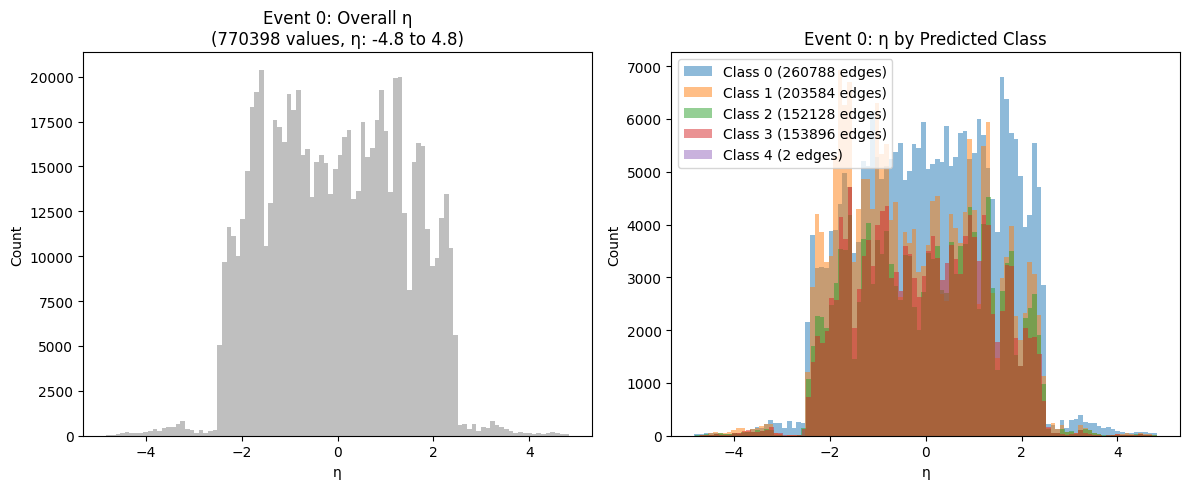

Event 1: 347964 edges
Predicted classes: [0 1 2 3 4]
Class counts: [131776  82981  64734  68464      9]


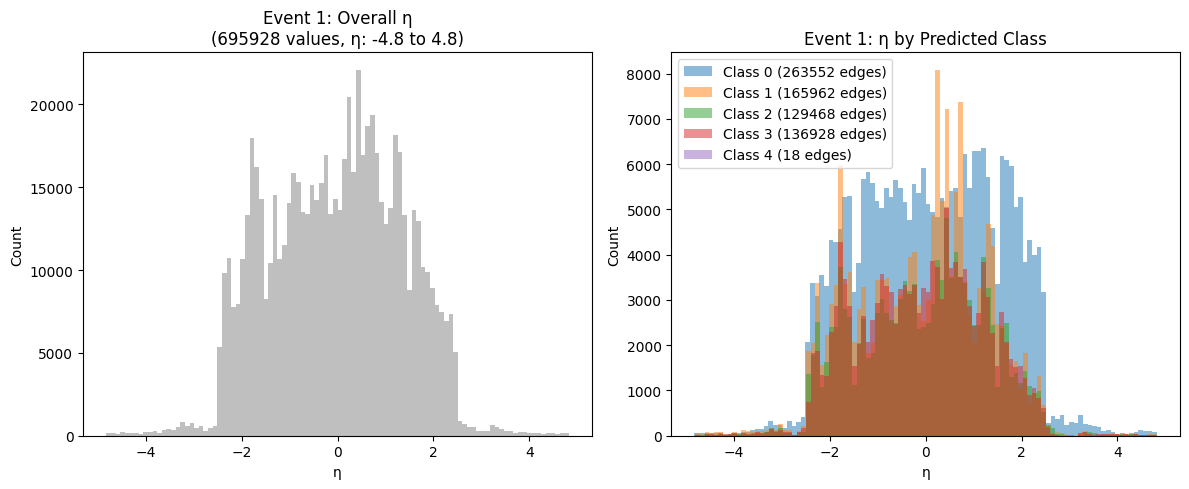

Event 2: 292521 edges
Predicted classes: [0 1 2 3]
Class counts: [127726  60613  52199  51983      0]


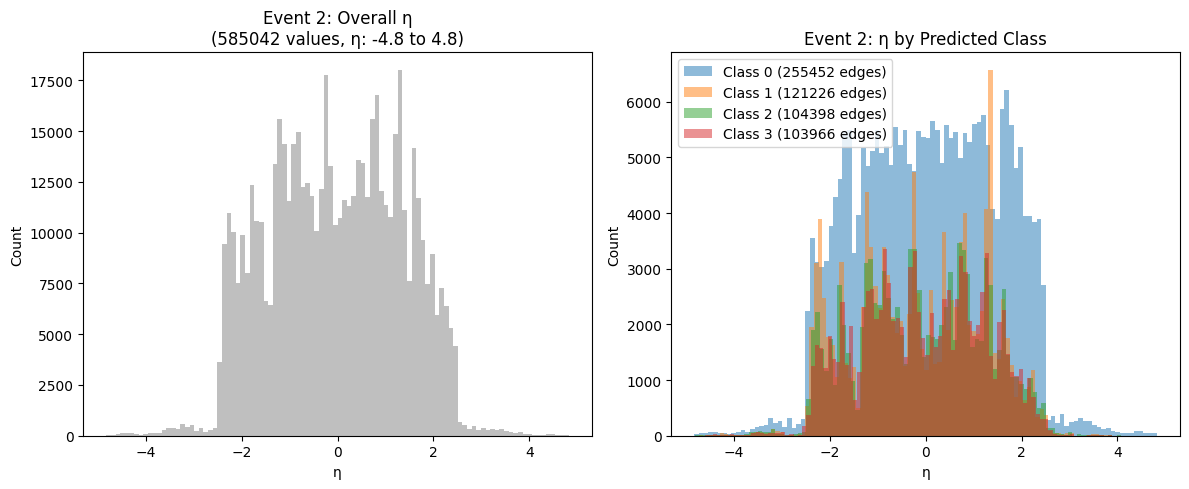

Event 3: 445070 edges
Predicted classes: [0 1 2 3]
Class counts: [132856 131600  89498  91116      0]


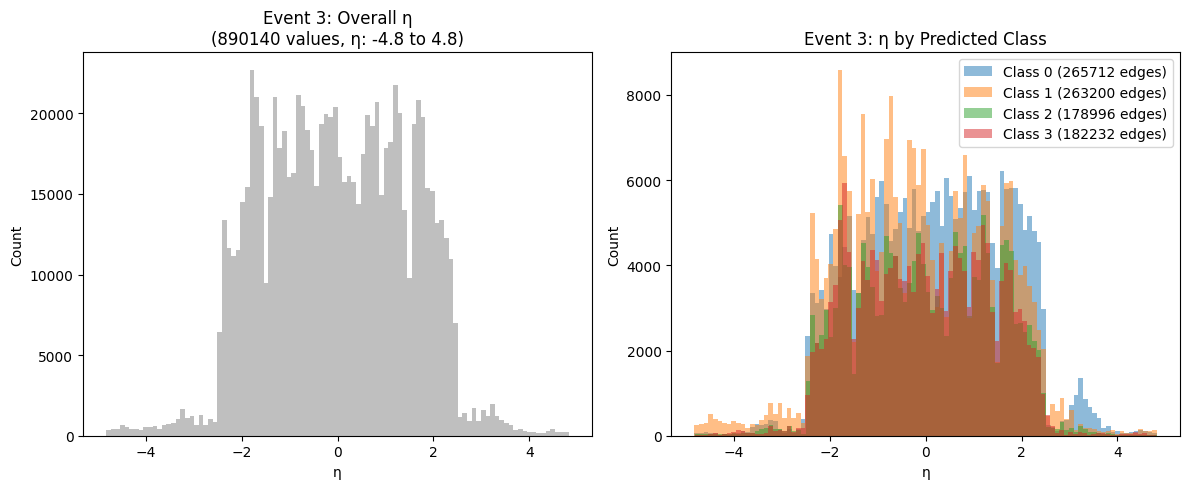

Event 4: 339133 edges
Predicted classes: [0 1 2 3 4]
Class counts: [133196  76734  63219  65977      7]


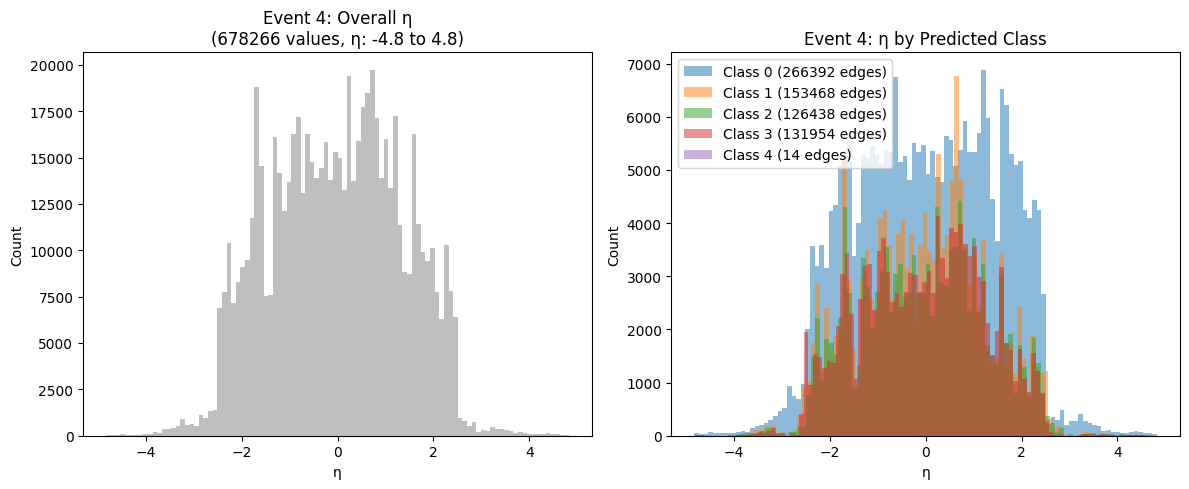

In [20]:
@torch.no_grad()
def run_inference_with_generator(model, generator, device, debug=False):
    """
    Inference using the generator, storing both full features and per-event results.
    """
    model.eval()
    all_results = []
    
    for i, (x_scaled, edge_index, edge_index_out, y, x_unscaled) in enumerate(generator):
        if debug and i % 10 == 0:
            print(f"Processing event {i}")
        
        # Move to device
        x_scaled = x_scaled.to(device)
        edge_index = edge_index.to(device)
        edge_index_out = edge_index_out.to(device)
        
        # Forward pass
        out = model([x_scaled], [edge_index], [edge_index_out])
        preds = out.argmax(dim=1).cpu().numpy()
        scores = torch.softmax(out, dim=1).cpu().numpy()
        
        # Edge endpoints
        src_nodes = edge_index_out[0].cpu()
        dst_nodes = edge_index_out[1].cpu()
        
        # Features (scaled + unscaled)
        feats_i_scaled = x_scaled[src_nodes].cpu().numpy()
        feats_j_scaled = x_scaled[dst_nodes].cpu().numpy()
        feats_i_unscaled = x_unscaled[src_nodes].numpy()
        feats_j_unscaled = x_unscaled[dst_nodes].numpy()
        
        # η values from unscaled features
        eta_i = feats_i_unscaled[:, 1]   # assuming column 1 = η
        eta_j = feats_j_unscaled[:, 1]
        
        # Store results for this event
        event_results = {
            "event_id": i,
            "preds": preds,
            "scores": scores,
            "labels": y.squeeze().numpy() if y is not None else None,
            "neighbor_pairs": edge_index_out.cpu().numpy().T,
            "features_i_scaled": feats_i_scaled,
            "features_j_scaled": feats_j_scaled,
            "features_i_unscaled": feats_i_unscaled,
            "features_j_unscaled": feats_j_unscaled,
            "eta_i": eta_i,
            "eta_j": eta_j,
        }
        all_results.append(event_results)
        
        if debug and i >= 4:  # Just process 5 events for debugging
            break
    
    return all_results

# Run inference with the working generator
results = run_inference_with_generator(model, gen, device, debug=True)

# Now plot the results
def plot_inference_results(results, num_events=5):
    """
    Plot inference results from the working generator
    """
    for i, event_result in enumerate(results):
        if i >= num_events:
            break
            
        preds = event_result['preds']
        eta_i = event_result['eta_i']
        eta_j = event_result['eta_j']
        labels = event_result['labels']
        
        print(f"Event {i}: {len(preds)} edges")
        print(f"Predicted classes: {np.unique(preds)}")
        print(f"Class counts: {np.bincount(preds, minlength=5)}")
        
        # Overall η distribution
        eta_all = np.concatenate([eta_i, eta_j])
        
        plt.figure(figsize=(12, 5))
        
        # Left plot: overall η
        plt.subplot(1, 2, 1)
        plt.hist(eta_all, bins=100, alpha=0.5, color='gray')
        plt.title(f"Event {i}: Overall η\n({len(eta_all)} values, η: {eta_all.min():.1f} to {eta_all.max():.1f})")
        plt.xlabel("η")
        plt.ylabel("Count")
        
        # Right plot: η by predicted class
        plt.subplot(1, 2, 2)
        for cls in np.unique(preds):
            cls_mask = preds == cls
            eta_cls = np.concatenate([eta_i[cls_mask], eta_j[cls_mask]])
            plt.hist(eta_cls, bins=100, alpha=0.5, label=f"Class {cls} ({len(eta_cls)} edges)")
        
        plt.title(f"Event {i}: η by Predicted Class")
        plt.xlabel("η")
        plt.ylabel("Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Plot the results
plot_inference_results(results, num_events=5)